<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Model-and-Plot-Model-Performance" data-toc-modified-id="Load-Model-and-Plot-Model-Performance-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Model and Plot Model Performance</a></span><ul class="toc-item"><li><span><a href="#Average-Error" data-toc-modified-id="Average-Error-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Average Error</a></span></li></ul></li><li><span><a href="#Inference-Object" data-toc-modified-id="Inference-Object-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inference Object</a></span></li><li><span><a href="#Effect-of-Reduced-Burning" data-toc-modified-id="Effect-of-Reduced-Burning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Effect of Reduced Burning</a></span><ul class="toc-item"><li><span><a href="#Effect-on-Seasonal-Pattern" data-toc-modified-id="Effect-on-Seasonal-Pattern-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Effect on Seasonal Pattern</a></span></li><li><span><a href="#Effect-On-Average-Pollution-Level" data-toc-modified-id="Effect-On-Average-Pollution-Level-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Effect On Average Pollution Level</a></span></li></ul></li><li><span><a href="#Animation" data-toc-modified-id="Animation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Animation</a></span></li><li><span><a href="#Additional-Plot" data-toc-modified-id="Additional-Plot-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Additional Plot</a></span></li></ul></div>

In [1]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.visualization.vis_data import *
from src.visualization.vis_model import *
from src.models.predict_model import * 
# set font size 
plt.rcParams.update({'font.size': 16})

The data between 1st October 2017 and 15th June 2020 are set aside as a test dataset during the model optimization process. In this section, the prediction dataset is used for studying the effect of reduced burning activities, which is the major source of air pollution in Chiang Mai. The fitted model will be used to predict the pollution levels in a scenario where the burning activities decreased. 

The simulation is not the same as the prediction of the test data in the Plot Model Performance section, where the actual fire activities and the weather conditions were used to predict the pollution levels. In the simulation and in the actual situation, the fire and the weather information is not known, and one has to use the ranges of possible values from previous years to obtain a range of pollution levels in the prediction dataset. I call this method of statistical prediction.

# Load Model and Plot Model Performance

In [3]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Chiang Mai', pollutant='PM2.5')

raw model performance {'test_r2_score': 0.7431, 'test_mean_squared_error': 274.499, 'test_mean_absolute_error': 10.4714, 'test_r2': 0.8573}
daily avg training error {'avg_trn_r2_score': 0.9452, 'avg_trn_mean_squared_error': 36.1641, 'avg_trn_mean_absolute_error': 3.7732, 'avg_trn_r2': 0.9731}
daily avg test error {'avg_test_r2_score': 0.7982, 'avg_test_mean_squared_error': 135.6166, 'avg_test_mean_absolute_error': 7.6241, 'avg_test_r2': 0.8951}


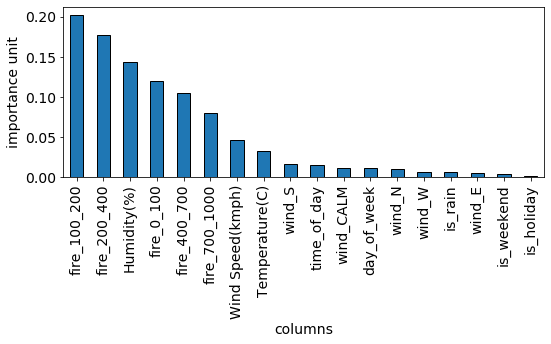

In [20]:
show_fea_imp(feat_imp,x_log=False, filename=None,title='')

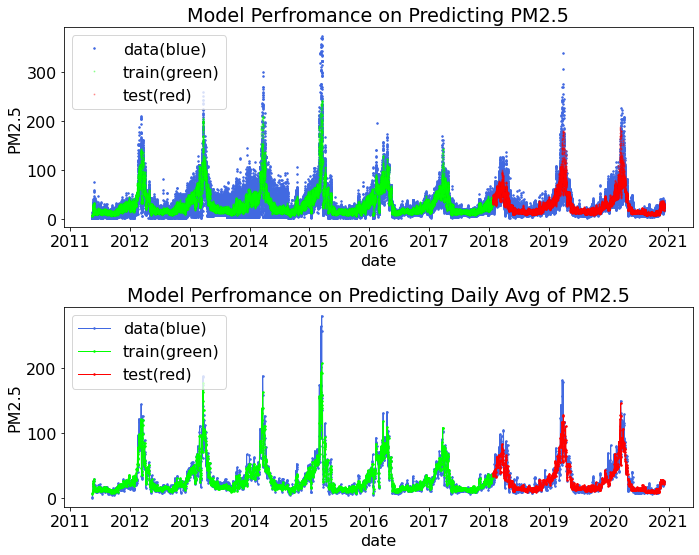

In [5]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=dataset, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

In [346]:
# calculate the average error for the training data
trn_error = cal_error(data, model, data_index=data.split_list[0])

# resample
ytrn_pred_df_avg = trn_error.resample('d').mean().dropna()
cal_scores(ytrn_pred_df_avg['actual'].values, ytrn_pred_df_avg['pred'].values, header_str='avg_trn_')

{'avg_trn_r2_score': 0.9450132986667232,
 'avg_trn_mean_squared_error': 35.925725806931965,
 'avg_trn_mean_absolute_error': 3.7745352329778226}

In [347]:
# calculate the average error for the test data
ytest_pred_df = cal_error(data, model, data_index=data.split_list[1])
# resample
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()
cal_scores(ytest_pred_df_avg['actual'].values, ytest_pred_df_avg['pred'].values, header_str='avg_test_')

{'avg_test_r2_score': 0.7828068417310021,
 'avg_test_mean_squared_error': 145.74247345984156,
 'avg_test_mean_absolute_error': 7.717591182233365}

## Average Error

Text(0.5, 1.0, 'error (by pollution season)')

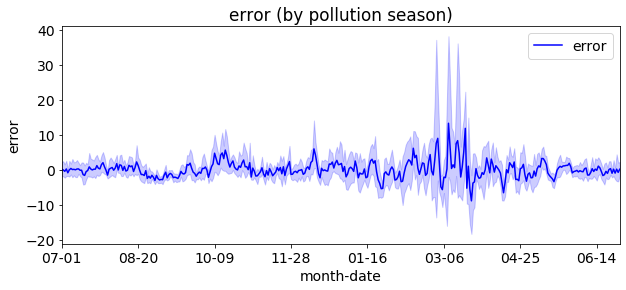

In [348]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'error', ax, plot_error=True, roll=False, agg='mean')
ax.set_title('error (by pollution season)')

Text(0.5, 1.0, 'rmse (by pollution season)')

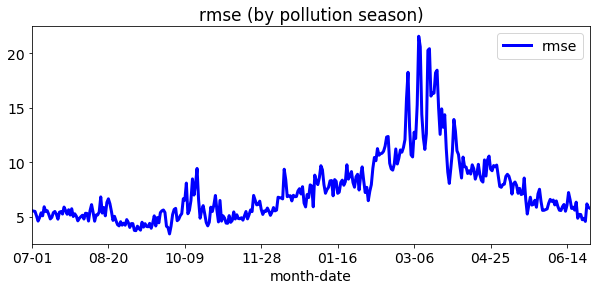

In [349]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'rmse', ax, plot_error=False, roll=True, agg='mean')
ax.set_title('rmse (by pollution season)')

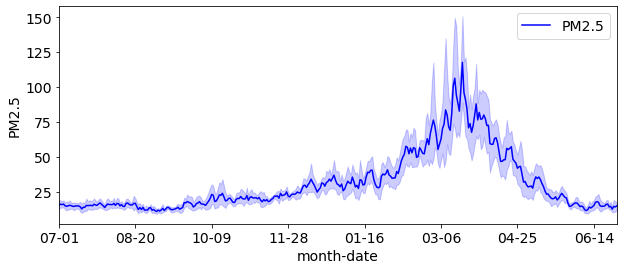

In [194]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(data.data, 'PM2.5', ax, plot_error=True, roll=False, agg='mean')

# Inference Object

The statistical prediction is performed by obtaining a range of possible weather data, and fire activities from the training dataset. For a particular date of year and time of day in a test dataset, we sample from the data in the training dataset with similar date-time information. For example, the weather condition for 1st October 2017 at 10 am is obtained from data between 20th August and 10th October, between 9 and 11 am in previous years. The data must be from a similar time of day because the weather conditions are very different between day and night times. Moreover, since the data with recent years are likely to be similar to the data in the prediction dataset, the training dataset from the previous year is assigned twice more weight than the data in the year before. 

The range of possible independent variables was used to predict a range of possible hourly PM2.5 levels. The values from the same date-time are then averaged to produce final prediction values. Figure 13 compares the daily average of actual PM2.5(blue) and the statistical prediction(red). The statistical simulation is very similar to the values of the actual data. 

For convenience, `Inferer` object in `src.visualization.predict_model.py`is responsible sampling data from the history and perform simulation.  

In [4]:
# init Inferer
inferer = Inferer(city_name='Chiang Mai', pollutant='PM2.5')
# a dataset object if one of Inferer's attributes
dataset = inferer.dataset

raw model performance {'test_r2_score': 0.7431, 'test_mean_squared_error': 274.499, 'test_mean_absolute_error': 10.4714, 'test_r2': 0.8573}
daily avg training error {'avg_trn_r2_score': 0.9452, 'avg_trn_mean_squared_error': 36.1641, 'avg_trn_mean_absolute_error': 3.7732, 'avg_trn_r2': 0.9731}
daily avg test error {'avg_test_r2_score': 0.7982, 'avg_test_mean_squared_error': 135.6166, 'avg_test_mean_absolute_error': 7.6241, 'avg_test_r2': 0.8951}
max error 18.29850999981331


`inferer.get_data_sample_()` Create a range of possible values by sampling from the history, weighing more recent year twice more than earlier years.

In [9]:
%%time
inferer.get_data_sample_(n_samples=20, step=1, day_err=10, hour_err=2)

obtaining inference samples. This will take about 15 mins





  0%|                                                                                                                             | 0/25095 [00:00<?, ?it/s]


  0%|                                                                                                                   | 2/25095 [00:00<1:16:03,  5.50it/s]


  0%|                                                                                                                  | 4/25095 [00:20<21:43:43,  3.12s/it]


  0%|                                                                                                                  | 6/25095 [00:20<15:23:38,  2.21s/it]


  0%|                                                                                                                 | 10/25095 [00:20<10:52:29,  1.56s/it]


  0%|                                                                                                                  | 12/25095 [00:20<7:43:22,  1.11s/it]


  0%|                                      

  1%|▊                                                                                                                  | 166/25095 [00:27<15:18, 27.13it/s]


  1%|▊                                                                                                                  | 170/25095 [00:27<15:35, 26.65it/s]


  1%|▊                                                                                                                  | 174/25095 [00:27<15:04, 27.57it/s]


  1%|▊                                                                                                                  | 178/25095 [00:27<14:30, 28.63it/s]


  1%|▊                                                                                                                  | 182/25095 [00:27<15:07, 27.46it/s]


  1%|▊                                                                                                                  | 186/25095 [00:27<15:02, 27.60it/s]


  1%|▊                                        

  1%|█▋                                                                                                                 | 358/25095 [00:34<16:30, 24.97it/s]


  1%|█▋                                                                                                                 | 362/25095 [00:34<17:39, 23.34it/s]


  1%|█▋                                                                                                                 | 366/25095 [00:35<16:47, 24.53it/s]


  1%|█▋                                                                                                                 | 370/25095 [00:35<17:37, 23.39it/s]


  1%|█▋                                                                                                                 | 374/25095 [00:35<17:33, 23.46it/s]


  2%|█▋                                                                                                                 | 378/25095 [00:35<18:09, 22.68it/s]


  2%|█▊                                       

  2%|██▌                                                                                                                | 562/25095 [00:43<15:46, 25.92it/s]


  2%|██▌                                                                                                                | 566/25095 [00:43<15:53, 25.72it/s]


  2%|██▌                                                                                                                | 570/25095 [00:44<15:17, 26.72it/s]


  2%|██▋                                                                                                                | 574/25095 [00:44<15:50, 25.79it/s]


  2%|██▋                                                                                                                | 578/25095 [00:44<15:31, 26.31it/s]


  2%|██▋                                                                                                                | 582/25095 [00:44<15:56, 25.63it/s]


  2%|██▋                                      

  3%|███▍                                                                                                               | 754/25095 [00:52<15:52, 25.56it/s]


  3%|███▍                                                                                                               | 758/25095 [00:52<15:18, 26.48it/s]


  3%|███▍                                                                                                               | 762/25095 [00:52<15:25, 26.29it/s]


  3%|███▌                                                                                                               | 766/25095 [00:52<15:30, 26.14it/s]


  3%|███▌                                                                                                               | 770/25095 [00:52<15:09, 26.74it/s]


  3%|███▌                                                                                                               | 774/25095 [00:52<15:03, 26.91it/s]


  3%|███▌                                     

  4%|████▎                                                                                                              | 946/25095 [00:59<16:54, 23.80it/s]


  4%|████▎                                                                                                              | 950/25095 [01:00<16:07, 24.95it/s]


  4%|████▎                                                                                                              | 954/25095 [01:00<15:37, 25.76it/s]


  4%|████▍                                                                                                              | 958/25095 [01:00<15:39, 25.68it/s]


  4%|████▍                                                                                                              | 962/25095 [01:00<16:09, 24.89it/s]


  4%|████▍                                                                                                              | 966/25095 [01:00<15:21, 26.17it/s]


  4%|████▍                                    

  5%|█████▏                                                                                                            | 1142/25095 [01:07<16:08, 24.74it/s]


  5%|█████▏                                                                                                            | 1146/25095 [01:07<15:27, 25.83it/s]


  5%|█████▏                                                                                                            | 1150/25095 [01:07<16:41, 23.92it/s]


  5%|█████▏                                                                                                            | 1154/25095 [01:07<16:27, 24.24it/s]


  5%|█████▎                                                                                                            | 1158/25095 [01:08<16:17, 24.48it/s]


  5%|█████▎                                                                                                            | 1162/25095 [01:08<16:04, 24.82it/s]


  5%|█████▎                                   

  5%|██████                                                                                                            | 1338/25095 [01:15<14:30, 27.29it/s]


  5%|██████                                                                                                            | 1342/25095 [01:15<15:12, 26.03it/s]


  5%|██████                                                                                                            | 1346/25095 [01:15<14:41, 26.93it/s]


  5%|██████▏                                                                                                           | 1350/25095 [01:15<14:41, 26.93it/s]


  5%|██████▏                                                                                                           | 1354/25095 [01:15<14:31, 27.23it/s]


  5%|██████▏                                                                                                           | 1358/25095 [01:15<14:45, 26.81it/s]


  5%|██████▏                                  

  6%|██████▉                                                                                                           | 1530/25095 [01:22<14:15, 27.55it/s]


  6%|██████▉                                                                                                           | 1534/25095 [01:22<14:43, 26.67it/s]


  6%|██████▉                                                                                                           | 1538/25095 [01:22<14:19, 27.41it/s]


  6%|███████                                                                                                           | 1542/25095 [01:22<14:07, 27.78it/s]


  6%|███████                                                                                                           | 1546/25095 [01:22<14:17, 27.48it/s]


  6%|███████                                                                                                           | 1550/25095 [01:22<13:56, 28.16it/s]


  6%|███████                                  

  7%|███████▊                                                                                                          | 1722/25095 [01:28<14:45, 26.39it/s]


  7%|███████▊                                                                                                          | 1726/25095 [01:28<13:24, 29.03it/s]


  7%|███████▊                                                                                                          | 1730/25095 [01:29<13:22, 29.12it/s]


  7%|███████▉                                                                                                          | 1734/25095 [01:29<13:20, 29.19it/s]


  7%|███████▉                                                                                                          | 1738/25095 [01:29<14:08, 27.53it/s]


  7%|███████▉                                                                                                          | 1742/25095 [01:29<13:35, 28.62it/s]


  7%|███████▉                                 

  8%|████████▋                                                                                                         | 1918/25095 [01:35<15:03, 25.66it/s]


  8%|████████▋                                                                                                         | 1922/25095 [01:36<13:48, 27.96it/s]


  8%|████████▋                                                                                                         | 1926/25095 [01:36<14:28, 26.69it/s]


  8%|████████▊                                                                                                         | 1930/25095 [01:36<14:25, 26.78it/s]


  8%|████████▊                                                                                                         | 1934/25095 [01:36<14:12, 27.16it/s]


  8%|████████▊                                                                                                         | 1938/25095 [01:36<14:53, 25.92it/s]


  8%|████████▊                                

  8%|█████████▌                                                                                                        | 2110/25095 [01:43<14:53, 25.71it/s]


  8%|█████████▌                                                                                                        | 2114/25095 [01:43<14:35, 26.24it/s]


  8%|█████████▌                                                                                                        | 2118/25095 [01:43<13:50, 27.68it/s]


  8%|█████████▋                                                                                                        | 2122/25095 [01:43<13:54, 27.52it/s]


  8%|█████████▋                                                                                                        | 2126/25095 [01:43<13:54, 27.52it/s]


  8%|█████████▋                                                                                                        | 2130/25095 [01:43<13:55, 27.48it/s]


  9%|█████████▋                               

  9%|██████████▍                                                                                                       | 2302/25095 [01:50<14:26, 26.29it/s]


  9%|██████████▍                                                                                                       | 2306/25095 [01:50<14:14, 26.67it/s]


  9%|██████████▍                                                                                                       | 2310/25095 [01:50<13:57, 27.21it/s]


  9%|██████████▌                                                                                                       | 2314/25095 [01:50<14:02, 27.03it/s]


  9%|██████████▌                                                                                                       | 2318/25095 [01:50<13:38, 27.83it/s]


  9%|██████████▌                                                                                                       | 2322/25095 [01:50<13:21, 28.43it/s]


  9%|██████████▌                              

 10%|███████████▎                                                                                                      | 2494/25095 [01:57<14:59, 25.13it/s]


 10%|███████████▎                                                                                                      | 2498/25095 [01:57<14:56, 25.21it/s]


 10%|███████████▎                                                                                                      | 2502/25095 [01:57<14:54, 25.27it/s]


 10%|███████████▍                                                                                                      | 2506/25095 [01:57<14:33, 25.87it/s]


 10%|███████████▍                                                                                                      | 2510/25095 [01:57<14:10, 26.56it/s]


 10%|███████████▍                                                                                                      | 2514/25095 [01:58<13:58, 26.92it/s]


 10%|███████████▍                             

 11%|████████████▏                                                                                                     | 2686/25095 [02:04<15:13, 24.53it/s]


 11%|████████████▏                                                                                                     | 2690/25095 [02:04<14:46, 25.27it/s]


 11%|████████████▏                                                                                                     | 2694/25095 [02:04<14:05, 26.51it/s]


 11%|████████████▎                                                                                                     | 2698/25095 [02:05<13:50, 26.98it/s]


 11%|████████████▎                                                                                                     | 2702/25095 [02:05<13:52, 26.91it/s]


 11%|████████████▎                                                                                                     | 2706/25095 [02:05<13:47, 27.06it/s]


 11%|████████████▎                            

 11%|█████████████                                                                                                     | 2878/25095 [02:12<15:23, 24.07it/s]


 11%|█████████████                                                                                                     | 2882/25095 [02:12<15:05, 24.54it/s]


 12%|█████████████                                                                                                     | 2886/25095 [02:12<14:41, 25.18it/s]


 12%|█████████████▏                                                                                                    | 2890/25095 [02:12<14:20, 25.80it/s]


 12%|█████████████▏                                                                                                    | 2894/25095 [02:12<14:14, 25.98it/s]


 12%|█████████████▏                                                                                                    | 2898/25095 [02:12<14:00, 26.41it/s]


 12%|█████████████▏                           

 12%|█████████████▉                                                                                                    | 3070/25095 [02:19<15:33, 23.58it/s]


 12%|█████████████▉                                                                                                    | 3074/25095 [02:19<14:34, 25.17it/s]


 12%|█████████████▉                                                                                                    | 3078/25095 [02:19<14:38, 25.07it/s]


 12%|██████████████                                                                                                    | 3082/25095 [02:20<14:15, 25.73it/s]


 12%|██████████████                                                                                                    | 3086/25095 [02:20<13:50, 26.51it/s]


 12%|██████████████                                                                                                    | 3090/25095 [02:20<14:16, 25.70it/s]


 12%|██████████████                           

 13%|██████████████▊                                                                                                   | 3262/25095 [02:27<15:14, 23.87it/s]


 13%|██████████████▊                                                                                                   | 3266/25095 [02:27<14:56, 24.36it/s]


 13%|██████████████▊                                                                                                   | 3270/25095 [02:27<14:15, 25.51it/s]


 13%|██████████████▊                                                                                                   | 3274/25095 [02:27<13:49, 26.30it/s]


 13%|██████████████▉                                                                                                   | 3278/25095 [02:27<13:57, 26.06it/s]


 13%|██████████████▉                                                                                                   | 3282/25095 [02:27<13:27, 27.01it/s]


 13%|██████████████▉                          

 14%|███████████████▋                                                                                                  | 3454/25095 [02:34<15:16, 23.61it/s]


 14%|███████████████▋                                                                                                  | 3458/25095 [02:34<14:25, 25.00it/s]


 14%|███████████████▋                                                                                                  | 3462/25095 [02:35<14:01, 25.72it/s]


 14%|███████████████▋                                                                                                  | 3466/25095 [02:35<13:55, 25.88it/s]


 14%|███████████████▊                                                                                                  | 3470/25095 [02:35<13:37, 26.46it/s]


 14%|███████████████▊                                                                                                  | 3474/25095 [02:35<13:27, 26.79it/s]


 14%|███████████████▊                         

 15%|████████████████▌                                                                                                 | 3646/25095 [02:42<14:53, 24.01it/s]


 15%|████████████████▌                                                                                                 | 3650/25095 [02:42<14:16, 25.04it/s]


 15%|████████████████▌                                                                                                 | 3654/25095 [02:42<14:24, 24.80it/s]


 15%|████████████████▌                                                                                                 | 3658/25095 [02:42<14:02, 25.44it/s]


 15%|████████████████▋                                                                                                 | 3662/25095 [02:42<13:23, 26.66it/s]


 15%|████████████████▋                                                                                                 | 3666/25095 [02:43<13:18, 26.85it/s]


 15%|████████████████▋                        

 15%|█████████████████▍                                                                                                | 3838/25095 [02:50<15:05, 23.48it/s]


 15%|█████████████████▍                                                                                                | 3842/25095 [02:50<14:27, 24.50it/s]


 15%|█████████████████▍                                                                                                | 3846/25095 [02:50<14:13, 24.90it/s]


 15%|█████████████████▍                                                                                                | 3850/25095 [02:50<13:54, 25.45it/s]


 15%|█████████████████▌                                                                                                | 3854/25095 [02:50<13:21, 26.50it/s]


 15%|█████████████████▌                                                                                                | 3858/25095 [02:50<13:05, 27.02it/s]


 15%|█████████████████▌                       

 16%|██████████████████▎                                                                                               | 4030/25095 [02:57<14:56, 23.49it/s]


 16%|██████████████████▎                                                                                               | 4034/25095 [02:57<14:15, 24.62it/s]


 16%|██████████████████▎                                                                                               | 4038/25095 [02:57<13:59, 25.10it/s]


 16%|██████████████████▎                                                                                               | 4042/25095 [02:58<13:21, 26.26it/s]


 16%|██████████████████▍                                                                                               | 4046/25095 [02:58<13:25, 26.13it/s]


 16%|██████████████████▍                                                                                               | 4050/25095 [02:58<13:05, 26.80it/s]


 16%|██████████████████▍                      

 17%|███████████████████▏                                                                                              | 4222/25095 [03:05<14:31, 23.96it/s]


 17%|███████████████████▏                                                                                              | 4226/25095 [03:05<14:08, 24.60it/s]


 17%|███████████████████▏                                                                                              | 4230/25095 [03:05<13:41, 25.40it/s]


 17%|███████████████████▏                                                                                              | 4234/25095 [03:05<13:31, 25.70it/s]


 17%|███████████████████▎                                                                                              | 4238/25095 [03:05<13:07, 26.48it/s]


 17%|███████████████████▎                                                                                              | 4242/25095 [03:05<12:58, 26.80it/s]


 17%|███████████████████▎                     

 18%|████████████████████                                                                                              | 4414/25095 [03:12<14:45, 23.36it/s]


 18%|████████████████████                                                                                              | 4418/25095 [03:12<13:57, 24.70it/s]


 18%|████████████████████                                                                                              | 4422/25095 [03:13<13:47, 24.99it/s]


 18%|████████████████████                                                                                              | 4426/25095 [03:13<13:15, 25.99it/s]


 18%|████████████████████                                                                                              | 4430/25095 [03:13<13:02, 26.39it/s]


 18%|████████████████████▏                                                                                             | 4434/25095 [03:13<13:10, 26.12it/s]


 18%|████████████████████▏                    

 18%|████████████████████▉                                                                                             | 4606/25095 [03:20<14:37, 23.34it/s]


 18%|████████████████████▉                                                                                             | 4610/25095 [03:20<14:43, 23.18it/s]


 18%|████████████████████▉                                                                                             | 4614/25095 [03:20<14:25, 23.66it/s]


 18%|████████████████████▉                                                                                             | 4618/25095 [03:21<14:04, 24.26it/s]


 18%|████████████████████▉                                                                                             | 4622/25095 [03:21<13:46, 24.76it/s]


 18%|█████████████████████                                                                                             | 4626/25095 [03:21<14:10, 24.06it/s]


 18%|█████████████████████                    

 19%|█████████████████████▊                                                                                            | 4798/25095 [03:28<13:49, 24.46it/s]


 19%|█████████████████████▊                                                                                            | 4802/25095 [03:28<13:33, 24.95it/s]


 19%|█████████████████████▊                                                                                            | 4806/25095 [03:28<13:34, 24.90it/s]


 19%|█████████████████████▊                                                                                            | 4810/25095 [03:28<13:07, 25.75it/s]


 19%|█████████████████████▊                                                                                            | 4814/25095 [03:28<13:04, 25.84it/s]


 19%|█████████████████████▉                                                                                            | 4818/25095 [03:28<13:01, 25.94it/s]


 19%|█████████████████████▉                   

 20%|██████████████████████▋                                                                                           | 4990/25095 [03:35<12:37, 26.54it/s]


 20%|██████████████████████▋                                                                                           | 4994/25095 [03:35<12:33, 26.68it/s]


 20%|██████████████████████▋                                                                                           | 4998/25095 [03:35<12:31, 26.74it/s]


 20%|██████████████████████▋                                                                                           | 5002/25095 [03:36<12:40, 26.40it/s]


 20%|██████████████████████▋                                                                                           | 5006/25095 [03:36<12:49, 26.10it/s]


 20%|██████████████████████▊                                                                                           | 5010/25095 [03:36<12:49, 26.12it/s]


 20%|██████████████████████▊                  

 21%|███████████████████████▌                                                                                          | 5182/25095 [03:42<12:22, 26.83it/s]


 21%|███████████████████████▌                                                                                          | 5186/25095 [03:42<12:40, 26.18it/s]


 21%|███████████████████████▌                                                                                          | 5190/25095 [03:43<12:20, 26.87it/s]


 21%|███████████████████████▌                                                                                          | 5194/25095 [03:43<12:33, 26.42it/s]


 21%|███████████████████████▌                                                                                          | 5198/25095 [03:43<12:38, 26.22it/s]


 21%|███████████████████████▋                                                                                          | 5202/25095 [03:43<12:23, 26.74it/s]


 21%|███████████████████████▋                 

 21%|████████████████████████▍                                                                                         | 5374/25095 [03:50<12:53, 25.51it/s]


 21%|████████████████████████▍                                                                                         | 5378/25095 [03:50<12:36, 26.07it/s]


 21%|████████████████████████▍                                                                                         | 5382/25095 [03:50<12:46, 25.71it/s]


 21%|████████████████████████▍                                                                                         | 5386/25095 [03:50<12:18, 26.67it/s]


 21%|████████████████████████▍                                                                                         | 5390/25095 [03:50<12:43, 25.82it/s]


 21%|████████████████████████▌                                                                                         | 5394/25095 [03:50<12:25, 26.42it/s]


 22%|████████████████████████▌                

 22%|█████████████████████████▎                                                                                        | 5566/25095 [03:58<13:57, 23.30it/s]


 22%|█████████████████████████▎                                                                                        | 5570/25095 [03:58<13:30, 24.10it/s]


 22%|█████████████████████████▎                                                                                        | 5574/25095 [03:58<12:46, 25.47it/s]


 22%|█████████████████████████▎                                                                                        | 5578/25095 [03:58<12:44, 25.53it/s]


 22%|█████████████████████████▎                                                                                        | 5582/25095 [03:58<12:32, 25.92it/s]


 22%|█████████████████████████▍                                                                                        | 5586/25095 [03:58<11:58, 27.14it/s]


 22%|█████████████████████████▍               

 23%|██████████████████████████▏                                                                                       | 5758/25095 [04:05<13:03, 24.68it/s]


 23%|██████████████████████████▏                                                                                       | 5762/25095 [04:05<12:59, 24.79it/s]


 23%|██████████████████████████▏                                                                                       | 5766/25095 [04:05<12:28, 25.84it/s]


 23%|██████████████████████████▏                                                                                       | 5770/25095 [04:06<12:14, 26.30it/s]


 23%|██████████████████████████▏                                                                                       | 5774/25095 [04:06<12:23, 25.99it/s]


 23%|██████████████████████████▏                                                                                       | 5778/25095 [04:06<12:15, 26.27it/s]


 23%|██████████████████████████▎              

 24%|██████████████████████████▉                                                                                       | 5928/25095 [04:47<34:22,  9.29it/s]


 24%|██████████████████████████▉                                                                                       | 5930/25095 [04:47<29:25, 10.85it/s]


 24%|██████████████████████████▉                                                                                       | 5932/25095 [04:47<25:52, 12.35it/s]


 24%|██████████████████████████▉                                                                                       | 5934/25095 [04:47<23:01, 13.87it/s]


 24%|██████████████████████████▉                                                                                       | 5936/25095 [04:47<21:19, 14.97it/s]


 24%|██████████████████████████▉                                                                                       | 5940/25095 [04:47<19:53, 16.05it/s]


 24%|██████████████████████████▉              

 24%|███████████████████████████▋                                                                                      | 6104/25095 [04:54<12:16, 25.78it/s]


 24%|███████████████████████████▋                                                                                      | 6108/25095 [04:54<11:56, 26.48it/s]


 24%|███████████████████████████▊                                                                                      | 6112/25095 [04:54<11:45, 26.90it/s]


 24%|███████████████████████████▊                                                                                      | 6116/25095 [04:54<11:33, 27.37it/s]


 24%|███████████████████████████▊                                                                                      | 6120/25095 [04:55<12:42, 24.88it/s]


 24%|███████████████████████████▊                                                                                      | 6124/25095 [04:55<12:19, 25.64it/s]


 24%|███████████████████████████▊             

 25%|████████████████████████████▌                                                                                     | 6296/25095 [05:01<11:55, 26.28it/s]


 25%|████████████████████████████▌                                                                                     | 6300/25095 [05:01<11:47, 26.58it/s]


 25%|████████████████████████████▋                                                                                     | 6304/25095 [05:02<12:06, 25.88it/s]


 25%|████████████████████████████▋                                                                                     | 6308/25095 [05:02<11:40, 26.82it/s]


 25%|████████████████████████████▋                                                                                     | 6312/25095 [05:02<12:49, 24.40it/s]


 25%|████████████████████████████▋                                                                                     | 6316/25095 [05:02<12:09, 25.73it/s]


 25%|████████████████████████████▋            

 26%|█████████████████████████████▍                                                                                    | 6488/25095 [05:09<11:43, 26.46it/s]


 26%|█████████████████████████████▍                                                                                    | 6492/25095 [05:09<11:40, 26.58it/s]


 26%|█████████████████████████████▌                                                                                    | 6496/25095 [05:09<11:32, 26.85it/s]


 26%|█████████████████████████████▌                                                                                    | 6500/25095 [05:09<11:27, 27.05it/s]


 26%|█████████████████████████████▌                                                                                    | 6504/25095 [05:09<12:02, 25.72it/s]


 26%|█████████████████████████████▌                                                                                    | 6508/25095 [05:09<11:22, 27.22it/s]


 26%|█████████████████████████████▌           

 27%|██████████████████████████████▎                                                                                   | 6680/25095 [05:16<12:32, 24.46it/s]


 27%|██████████████████████████████▎                                                                                   | 6684/25095 [05:16<12:27, 24.63it/s]


 27%|██████████████████████████████▍                                                                                   | 6688/25095 [05:16<12:43, 24.11it/s]


 27%|██████████████████████████████▍                                                                                   | 6692/25095 [05:16<12:05, 25.36it/s]


 27%|██████████████████████████████▍                                                                                   | 6696/25095 [05:17<12:18, 24.92it/s]


 27%|██████████████████████████████▍                                                                                   | 6700/25095 [05:17<12:22, 24.76it/s]


 27%|██████████████████████████████▍          

 27%|███████████████████████████████▏                                                                                  | 6872/25095 [05:23<12:18, 24.67it/s]


 27%|███████████████████████████████▏                                                                                  | 6876/25095 [05:24<12:21, 24.58it/s]


 27%|███████████████████████████████▎                                                                                  | 6880/25095 [05:24<12:36, 24.09it/s]


 27%|███████████████████████████████▎                                                                                  | 6884/25095 [05:24<12:16, 24.71it/s]


 27%|███████████████████████████████▎                                                                                  | 6888/25095 [05:24<12:35, 24.09it/s]


 27%|███████████████████████████████▎                                                                                  | 6892/25095 [05:24<12:57, 23.42it/s]


 27%|███████████████████████████████▎         

 28%|████████████████████████████████                                                                                  | 7064/25095 [05:31<11:10, 26.90it/s]


 28%|████████████████████████████████                                                                                  | 7068/25095 [05:31<10:57, 27.41it/s]


 28%|████████████████████████████████▏                                                                                 | 7072/25095 [05:31<10:54, 27.53it/s]


 28%|████████████████████████████████▏                                                                                 | 7076/25095 [05:31<11:02, 27.21it/s]


 28%|████████████████████████████████▏                                                                                 | 7080/25095 [05:31<10:43, 27.98it/s]


 28%|████████████████████████████████▏                                                                                 | 7084/25095 [05:32<10:51, 27.66it/s]


 28%|████████████████████████████████▏        

 29%|████████████████████████████████▉                                                                                 | 7256/25095 [05:38<10:50, 27.42it/s]


 29%|████████████████████████████████▉                                                                                 | 7260/25095 [05:38<11:06, 26.77it/s]


 29%|████████████████████████████████▉                                                                                 | 7264/25095 [05:38<11:05, 26.81it/s]


 29%|█████████████████████████████████                                                                                 | 7268/25095 [05:38<10:52, 27.30it/s]


 29%|█████████████████████████████████                                                                                 | 7272/25095 [05:38<10:59, 27.01it/s]


 29%|█████████████████████████████████                                                                                 | 7276/25095 [05:39<11:12, 26.51it/s]


 29%|█████████████████████████████████        

 30%|█████████████████████████████████▊                                                                                | 7448/25095 [05:45<10:57, 26.84it/s]


 30%|█████████████████████████████████▊                                                                                | 7452/25095 [05:45<10:53, 27.01it/s]


 30%|█████████████████████████████████▊                                                                                | 7456/25095 [05:45<11:03, 26.59it/s]


 30%|█████████████████████████████████▉                                                                                | 7460/25095 [05:46<10:59, 26.72it/s]


 30%|█████████████████████████████████▉                                                                                | 7464/25095 [05:46<10:46, 27.25it/s]


 30%|█████████████████████████████████▉                                                                                | 7468/25095 [05:46<11:06, 26.45it/s]


 30%|█████████████████████████████████▉       

 30%|██████████████████████████████████▋                                                                               | 7640/25095 [05:52<10:36, 27.44it/s]


 30%|██████████████████████████████████▋                                                                               | 7644/25095 [05:52<10:18, 28.21it/s]


 30%|██████████████████████████████████▋                                                                               | 7648/25095 [05:53<10:53, 26.70it/s]


 30%|██████████████████████████████████▊                                                                               | 7652/25095 [05:53<10:34, 27.48it/s]


 31%|██████████████████████████████████▊                                                                               | 7656/25095 [05:53<10:50, 26.79it/s]


 31%|██████████████████████████████████▊                                                                               | 7660/25095 [05:53<11:14, 25.85it/s]


 31%|██████████████████████████████████▊      

 31%|███████████████████████████████████▌                                                                              | 7832/25095 [05:59<10:33, 27.26it/s]


 31%|███████████████████████████████████▌                                                                              | 7836/25095 [06:00<10:52, 26.47it/s]


 31%|███████████████████████████████████▌                                                                              | 7840/25095 [06:00<10:40, 26.92it/s]


 31%|███████████████████████████████████▋                                                                              | 7844/25095 [06:00<10:24, 27.64it/s]


 31%|███████████████████████████████████▋                                                                              | 7848/25095 [06:00<10:36, 27.08it/s]


 31%|███████████████████████████████████▋                                                                              | 7852/25095 [06:00<10:38, 27.01it/s]


 31%|███████████████████████████████████▋     

 32%|████████████████████████████████████▍                                                                             | 8024/25095 [06:07<11:01, 25.80it/s]


 32%|████████████████████████████████████▍                                                                             | 8028/25095 [06:07<11:08, 25.53it/s]


 32%|████████████████████████████████████▍                                                                             | 8032/25095 [06:07<10:54, 26.05it/s]


 32%|████████████████████████████████████▌                                                                             | 8036/25095 [06:07<10:52, 26.15it/s]


 32%|████████████████████████████████████▌                                                                             | 8040/25095 [06:07<10:38, 26.71it/s]


 32%|████████████████████████████████████▌                                                                             | 8044/25095 [06:07<10:19, 27.53it/s]


 32%|████████████████████████████████████▌    

 33%|█████████████████████████████████████▎                                                                            | 8216/25095 [06:14<10:54, 25.79it/s]


 33%|█████████████████████████████████████▎                                                                            | 8220/25095 [06:14<10:52, 25.85it/s]


 33%|█████████████████████████████████████▎                                                                            | 8224/25095 [06:14<10:27, 26.90it/s]


 33%|█████████████████████████████████████▍                                                                            | 8228/25095 [06:14<10:24, 27.02it/s]


 33%|█████████████████████████████████████▍                                                                            | 8232/25095 [06:14<10:44, 26.15it/s]


 33%|█████████████████████████████████████▍                                                                            | 8236/25095 [06:14<10:19, 27.20it/s]


 33%|█████████████████████████████████████▍   

 34%|██████████████████████████████████████▏                                                                           | 8408/25095 [06:21<10:13, 27.20it/s]


 34%|██████████████████████████████████████▏                                                                           | 8412/25095 [06:21<10:20, 26.88it/s]


 34%|██████████████████████████████████████▏                                                                           | 8416/25095 [06:21<10:20, 26.89it/s]


 34%|██████████████████████████████████████▏                                                                           | 8420/25095 [06:21<10:19, 26.90it/s]


 34%|██████████████████████████████████████▎                                                                           | 8424/25095 [06:21<10:24, 26.71it/s]


 34%|██████████████████████████████████████▎                                                                           | 8428/25095 [06:21<10:23, 26.71it/s]


 34%|██████████████████████████████████████▎  

 34%|███████████████████████████████████████                                                                           | 8600/25095 [06:28<09:54, 27.74it/s]


 34%|███████████████████████████████████████                                                                           | 8604/25095 [06:28<09:45, 28.19it/s]


 34%|███████████████████████████████████████                                                                           | 8608/25095 [06:28<09:53, 27.77it/s]


 34%|███████████████████████████████████████                                                                           | 8612/25095 [06:28<09:42, 28.30it/s]


 34%|███████████████████████████████████████▏                                                                          | 8616/25095 [06:28<09:58, 27.51it/s]


 34%|███████████████████████████████████████▏                                                                          | 8620/25095 [06:28<09:48, 27.98it/s]


 34%|███████████████████████████████████████▏ 

 35%|███████████████████████████████████████▉                                                                          | 8792/25095 [06:35<09:28, 28.67it/s]


 35%|███████████████████████████████████████▉                                                                          | 8796/25095 [06:35<09:38, 28.18it/s]


 35%|███████████████████████████████████████▉                                                                          | 8800/25095 [06:35<09:34, 28.34it/s]


 35%|███████████████████████████████████████▉                                                                          | 8804/25095 [06:35<09:32, 28.43it/s]


 35%|████████████████████████████████████████                                                                          | 8808/25095 [06:35<09:29, 28.58it/s]


 35%|████████████████████████████████████████                                                                          | 8812/25095 [06:35<09:20, 29.07it/s]


 35%|████████████████████████████████████████ 

 36%|████████████████████████████████████████▊                                                                         | 8984/25095 [06:41<09:26, 28.43it/s]


 36%|████████████████████████████████████████▊                                                                         | 8988/25095 [06:42<09:28, 28.32it/s]


 36%|████████████████████████████████████████▊                                                                         | 8992/25095 [06:42<09:44, 27.56it/s]


 36%|████████████████████████████████████████▊                                                                         | 8996/25095 [06:42<09:29, 28.26it/s]


 36%|████████████████████████████████████████▉                                                                         | 9000/25095 [06:42<09:35, 27.97it/s]


 36%|████████████████████████████████████████▉                                                                         | 9004/25095 [06:42<09:22, 28.59it/s]


 36%|████████████████████████████████████████▉

 37%|█████████████████████████████████████████▋                                                                        | 9176/25095 [06:48<09:28, 28.00it/s]


 37%|█████████████████████████████████████████▋                                                                        | 9180/25095 [06:48<09:18, 28.49it/s]


 37%|█████████████████████████████████████████▋                                                                        | 9184/25095 [06:48<09:09, 28.94it/s]


 37%|█████████████████████████████████████████▋                                                                        | 9188/25095 [06:48<09:25, 28.11it/s]


 37%|█████████████████████████████████████████▊                                                                        | 9192/25095 [06:49<09:14, 28.67it/s]


 37%|█████████████████████████████████████████▊                                                                        | 9196/25095 [06:49<09:14, 28.69it/s]


 37%|█████████████████████████████████████████

 37%|██████████████████████████████████████████▌                                                                       | 9368/25095 [06:55<09:06, 28.79it/s]


 37%|██████████████████████████████████████████▌                                                                       | 9372/25095 [06:55<09:01, 29.01it/s]


 37%|██████████████████████████████████████████▌                                                                       | 9376/25095 [06:55<08:59, 29.15it/s]


 37%|██████████████████████████████████████████▌                                                                       | 9380/25095 [06:55<08:56, 29.31it/s]


 37%|██████████████████████████████████████████▋                                                                       | 9384/25095 [06:55<08:59, 29.15it/s]


 37%|██████████████████████████████████████████▋                                                                       | 9388/25095 [06:55<09:15, 28.27it/s]


 37%|█████████████████████████████████████████

 38%|███████████████████████████████████████████▍                                                                      | 9560/25095 [07:01<08:30, 30.41it/s]


 38%|███████████████████████████████████████████▍                                                                      | 9564/25095 [07:01<08:57, 28.92it/s]


 38%|███████████████████████████████████████████▍                                                                      | 9568/25095 [07:02<08:56, 28.95it/s]


 38%|███████████████████████████████████████████▍                                                                      | 9572/25095 [07:02<08:52, 29.15it/s]


 38%|███████████████████████████████████████████▌                                                                      | 9576/25095 [07:02<08:47, 29.43it/s]


 38%|███████████████████████████████████████████▌                                                                      | 9580/25095 [07:02<08:40, 29.78it/s]


 38%|█████████████████████████████████████████

 39%|████████████████████████████████████████████▎                                                                     | 9752/25095 [07:08<08:53, 28.78it/s]


 39%|████████████████████████████████████████████▎                                                                     | 9756/25095 [07:08<08:34, 29.79it/s]


 39%|████████████████████████████████████████████▎                                                                     | 9760/25095 [07:08<08:32, 29.90it/s]


 39%|████████████████████████████████████████████▎                                                                     | 9764/25095 [07:08<08:35, 29.72it/s]


 39%|████████████████████████████████████████████▎                                                                     | 9768/25095 [07:08<08:39, 29.53it/s]


 39%|████████████████████████████████████████████▍                                                                     | 9772/25095 [07:09<08:49, 28.95it/s]


 39%|█████████████████████████████████████████

 40%|█████████████████████████████████████████████▏                                                                    | 9944/25095 [07:14<08:55, 28.29it/s]


 40%|█████████████████████████████████████████████▏                                                                    | 9948/25095 [07:15<09:13, 27.36it/s]


 40%|█████████████████████████████████████████████▏                                                                    | 9952/25095 [07:15<08:51, 28.49it/s]


 40%|█████████████████████████████████████████████▏                                                                    | 9956/25095 [07:15<09:01, 27.95it/s]


 40%|█████████████████████████████████████████████▏                                                                    | 9960/25095 [07:15<08:50, 28.54it/s]


 40%|█████████████████████████████████████████████▎                                                                    | 9964/25095 [07:15<08:29, 29.70it/s]


 40%|█████████████████████████████████████████

 40%|█████████████████████████████████████████████▋                                                                   | 10136/25095 [07:21<08:26, 29.54it/s]


 40%|█████████████████████████████████████████████▋                                                                   | 10140/25095 [07:21<08:34, 29.04it/s]


 40%|█████████████████████████████████████████████▋                                                                   | 10144/25095 [07:21<08:36, 28.96it/s]


 40%|█████████████████████████████████████████████▋                                                                   | 10148/25095 [07:22<08:39, 28.76it/s]


 40%|█████████████████████████████████████████████▋                                                                   | 10152/25095 [07:22<08:29, 29.34it/s]


 40%|█████████████████████████████████████████████▋                                                                   | 10156/25095 [07:22<08:35, 29.00it/s]


 40%|█████████████████████████████████████████

 41%|██████████████████████████████████████████████▌                                                                  | 10328/25095 [07:28<08:49, 27.90it/s]


 41%|██████████████████████████████████████████████▌                                                                  | 10332/25095 [07:28<08:37, 28.52it/s]


 41%|██████████████████████████████████████████████▌                                                                  | 10336/25095 [07:28<08:28, 29.04it/s]


 41%|██████████████████████████████████████████████▌                                                                  | 10340/25095 [07:28<08:14, 29.81it/s]


 41%|██████████████████████████████████████████████▌                                                                  | 10344/25095 [07:28<08:13, 29.88it/s]


 41%|██████████████████████████████████████████████▌                                                                  | 10348/25095 [07:29<08:29, 28.95it/s]


 41%|█████████████████████████████████████████

 42%|███████████████████████████████████████████████▎                                                                 | 10520/25095 [07:34<08:15, 29.44it/s]


 42%|███████████████████████████████████████████████▍                                                                 | 10524/25095 [07:35<08:24, 28.89it/s]


 42%|███████████████████████████████████████████████▍                                                                 | 10528/25095 [07:35<08:37, 28.13it/s]


 42%|███████████████████████████████████████████████▍                                                                 | 10532/25095 [07:35<08:40, 27.99it/s]


 42%|███████████████████████████████████████████████▍                                                                 | 10536/25095 [07:35<08:30, 28.54it/s]


 42%|███████████████████████████████████████████████▍                                                                 | 10540/25095 [07:35<08:23, 28.89it/s]


 42%|█████████████████████████████████████████

 43%|████████████████████████████████████████████████▏                                                                | 10712/25095 [07:41<08:13, 29.15it/s]


 43%|████████████████████████████████████████████████▎                                                                | 10716/25095 [07:41<08:01, 29.85it/s]


 43%|████████████████████████████████████████████████▎                                                                | 10720/25095 [07:41<08:03, 29.76it/s]


 43%|████████████████████████████████████████████████▎                                                                | 10724/25095 [07:41<08:24, 28.49it/s]


 43%|████████████████████████████████████████████████▎                                                                | 10728/25095 [07:42<08:18, 28.84it/s]


 43%|████████████████████████████████████████████████▎                                                                | 10732/25095 [07:42<08:15, 28.98it/s]


 43%|█████████████████████████████████████████

 43%|█████████████████████████████████████████████████                                                                | 10904/25095 [07:48<08:29, 27.86it/s]


 43%|█████████████████████████████████████████████████                                                                | 10908/25095 [07:48<08:12, 28.79it/s]


 43%|█████████████████████████████████████████████████▏                                                               | 10912/25095 [07:48<08:24, 28.10it/s]


 43%|█████████████████████████████████████████████████▏                                                               | 10916/25095 [07:48<08:08, 29.01it/s]


 44%|█████████████████████████████████████████████████▏                                                               | 10920/25095 [07:48<08:21, 28.24it/s]


 44%|█████████████████████████████████████████████████▏                                                               | 10924/25095 [07:48<08:15, 28.62it/s]


 44%|█████████████████████████████████████████

 44%|█████████████████████████████████████████████████▉                                                               | 11096/25095 [07:54<07:54, 29.50it/s]


 44%|█████████████████████████████████████████████████▉                                                               | 11100/25095 [07:55<08:13, 28.35it/s]


 44%|██████████████████████████████████████████████████                                                               | 11104/25095 [07:55<08:05, 28.84it/s]


 44%|██████████████████████████████████████████████████                                                               | 11108/25095 [07:55<07:58, 29.22it/s]


 44%|██████████████████████████████████████████████████                                                               | 11112/25095 [07:55<08:13, 28.35it/s]


 44%|██████████████████████████████████████████████████                                                               | 11116/25095 [07:55<08:12, 28.36it/s]


 44%|█████████████████████████████████████████

 45%|██████████████████████████████████████████████████▊                                                              | 11288/25095 [08:01<08:00, 28.73it/s]


 45%|██████████████████████████████████████████████████▊                                                              | 11292/25095 [08:01<07:59, 28.76it/s]


 45%|██████████████████████████████████████████████████▊                                                              | 11296/25095 [08:01<07:57, 28.89it/s]


 45%|██████████████████████████████████████████████████▉                                                              | 11300/25095 [08:01<07:51, 29.25it/s]


 45%|██████████████████████████████████████████████████▉                                                              | 11304/25095 [08:02<08:04, 28.49it/s]


 45%|██████████████████████████████████████████████████▉                                                              | 11308/25095 [08:02<08:17, 27.72it/s]


 45%|█████████████████████████████████████████

 46%|███████████████████████████████████████████████████▋                                                             | 11480/25095 [08:08<08:06, 27.97it/s]


 46%|███████████████████████████████████████████████████▋                                                             | 11484/25095 [08:08<07:55, 28.64it/s]


 46%|███████████████████████████████████████████████████▋                                                             | 11488/25095 [08:08<07:53, 28.73it/s]


 46%|███████████████████████████████████████████████████▋                                                             | 11492/25095 [08:08<08:01, 28.24it/s]


 46%|███████████████████████████████████████████████████▊                                                             | 11496/25095 [08:08<07:59, 28.36it/s]


 46%|███████████████████████████████████████████████████▊                                                             | 11500/25095 [08:09<07:56, 28.55it/s]


 46%|█████████████████████████████████████████

 47%|████████████████████████████████████████████████████▌                                                            | 11672/25095 [08:15<08:21, 26.76it/s]


 47%|████████████████████████████████████████████████████▌                                                            | 11676/25095 [08:15<08:13, 27.21it/s]


 47%|████████████████████████████████████████████████████▌                                                            | 11680/25095 [08:15<08:00, 27.90it/s]


 47%|████████████████████████████████████████████████████▌                                                            | 11684/25095 [08:15<08:05, 27.64it/s]


 47%|████████████████████████████████████████████████████▋                                                            | 11688/25095 [08:15<08:07, 27.51it/s]


 47%|████████████████████████████████████████████████████▋                                                            | 11692/25095 [08:16<08:11, 27.26it/s]


 47%|█████████████████████████████████████████

 47%|█████████████████████████████████████████████████████▍                                                           | 11864/25095 [08:22<08:07, 27.14it/s]


 47%|█████████████████████████████████████████████████████▍                                                           | 11868/25095 [08:22<07:58, 27.62it/s]


 47%|█████████████████████████████████████████████████████▍                                                           | 11872/25095 [08:22<07:59, 27.55it/s]


 47%|█████████████████████████████████████████████████████▍                                                           | 11876/25095 [08:22<07:46, 28.32it/s]


 47%|█████████████████████████████████████████████████████▍                                                           | 11880/25095 [08:22<07:54, 27.85it/s]


 47%|█████████████████████████████████████████████████████▌                                                           | 11884/25095 [08:23<07:49, 28.16it/s]


 47%|█████████████████████████████████████████

 48%|██████████████████████████████████████████████████████▎                                                          | 12056/25095 [08:29<07:50, 27.70it/s]


 48%|██████████████████████████████████████████████████████▎                                                          | 12060/25095 [08:29<07:59, 27.21it/s]


 48%|██████████████████████████████████████████████████████▎                                                          | 12064/25095 [08:29<07:43, 28.14it/s]


 48%|██████████████████████████████████████████████████████▎                                                          | 12068/25095 [08:29<07:51, 27.62it/s]


 48%|██████████████████████████████████████████████████████▎                                                          | 12072/25095 [08:29<07:43, 28.11it/s]


 48%|██████████████████████████████████████████████████████▍                                                          | 12076/25095 [08:29<07:39, 28.35it/s]


 48%|█████████████████████████████████████████

 49%|███████████████████████████████████████████████████████▏                                                         | 12248/25095 [08:36<07:42, 27.77it/s]


 49%|███████████████████████████████████████████████████████▏                                                         | 12252/25095 [08:36<07:35, 28.21it/s]


 49%|███████████████████████████████████████████████████████▏                                                         | 12256/25095 [08:36<08:23, 25.48it/s]


 49%|███████████████████████████████████████████████████████▏                                                         | 12260/25095 [08:36<08:02, 26.57it/s]


 49%|███████████████████████████████████████████████████████▏                                                         | 12264/25095 [08:36<08:04, 26.51it/s]


 49%|███████████████████████████████████████████████████████▏                                                         | 12268/25095 [08:36<07:48, 27.40it/s]


 49%|█████████████████████████████████████████

 50%|████████████████████████████████████████████████████████                                                         | 12440/25095 [08:43<07:49, 26.94it/s]


 50%|████████████████████████████████████████████████████████                                                         | 12444/25095 [08:43<07:42, 27.34it/s]


 50%|████████████████████████████████████████████████████████                                                         | 12448/25095 [08:43<07:34, 27.85it/s]


 50%|████████████████████████████████████████████████████████                                                         | 12452/25095 [08:43<07:23, 28.50it/s]


 50%|████████████████████████████████████████████████████████                                                         | 12456/25095 [08:43<07:46, 27.09it/s]


 50%|████████████████████████████████████████████████████████                                                         | 12460/25095 [08:43<07:53, 26.70it/s]


 50%|█████████████████████████████████████████

 50%|████████████████████████████████████████████████████████▉                                                        | 12632/25095 [08:50<07:34, 27.41it/s]


 50%|████████████████████████████████████████████████████████▉                                                        | 12636/25095 [08:50<07:41, 26.98it/s]


 50%|████████████████████████████████████████████████████████▉                                                        | 12640/25095 [08:50<07:24, 28.01it/s]


 50%|████████████████████████████████████████████████████████▉                                                        | 12644/25095 [08:50<07:21, 28.23it/s]


 50%|████████████████████████████████████████████████████████▉                                                        | 12648/25095 [08:50<07:24, 27.99it/s]


 50%|████████████████████████████████████████████████████████▉                                                        | 12652/25095 [08:50<07:19, 28.32it/s]


 50%|█████████████████████████████████████████

 51%|█████████████████████████████████████████████████████████▋                                                       | 12824/25095 [08:57<07:15, 28.19it/s]


 51%|█████████████████████████████████████████████████████████▊                                                       | 12828/25095 [08:57<07:25, 27.56it/s]


 51%|█████████████████████████████████████████████████████████▊                                                       | 12832/25095 [08:57<07:13, 28.30it/s]


 51%|█████████████████████████████████████████████████████████▊                                                       | 12836/25095 [08:57<07:18, 27.98it/s]


 51%|█████████████████████████████████████████████████████████▊                                                       | 12840/25095 [08:57<07:10, 28.45it/s]


 51%|█████████████████████████████████████████████████████████▊                                                       | 12844/25095 [08:57<07:12, 28.33it/s]


 51%|█████████████████████████████████████████

 52%|██████████████████████████████████████████████████████████▌                                                      | 13016/25095 [09:03<07:08, 28.16it/s]


 52%|██████████████████████████████████████████████████████████▋                                                      | 13020/25095 [09:04<07:32, 26.71it/s]


 52%|██████████████████████████████████████████████████████████▋                                                      | 13024/25095 [09:04<07:31, 26.75it/s]


 52%|██████████████████████████████████████████████████████████▋                                                      | 13028/25095 [09:04<07:19, 27.48it/s]


 52%|██████████████████████████████████████████████████████████▋                                                      | 13032/25095 [09:04<07:24, 27.13it/s]


 52%|██████████████████████████████████████████████████████████▋                                                      | 13036/25095 [09:04<07:16, 27.60it/s]


 52%|█████████████████████████████████████████

 53%|███████████████████████████████████████████████████████████▍                                                     | 13208/25095 [09:10<07:05, 27.93it/s]


 53%|███████████████████████████████████████████████████████████▍                                                     | 13212/25095 [09:11<07:08, 27.72it/s]


 53%|███████████████████████████████████████████████████████████▌                                                     | 13216/25095 [09:11<07:13, 27.43it/s]


 53%|███████████████████████████████████████████████████████████▌                                                     | 13220/25095 [09:11<07:01, 28.15it/s]


 53%|███████████████████████████████████████████████████████████▌                                                     | 13224/25095 [09:11<07:09, 27.67it/s]


 53%|███████████████████████████████████████████████████████████▌                                                     | 13228/25095 [09:11<07:00, 28.20it/s]


 53%|█████████████████████████████████████████

 53%|████████████████████████████████████████████████████████████▎                                                    | 13400/25095 [09:17<07:01, 27.77it/s]


 53%|████████████████████████████████████████████████████████████▎                                                    | 13404/25095 [09:17<07:02, 27.65it/s]


 53%|████████████████████████████████████████████████████████████▎                                                    | 13408/25095 [09:18<07:09, 27.24it/s]


 53%|████████████████████████████████████████████████████████████▍                                                    | 13412/25095 [09:18<07:01, 27.70it/s]


 53%|████████████████████████████████████████████████████████████▍                                                    | 13416/25095 [09:18<07:08, 27.23it/s]


 53%|████████████████████████████████████████████████████████████▍                                                    | 13420/25095 [09:18<06:59, 27.81it/s]


 53%|█████████████████████████████████████████

 54%|█████████████████████████████████████████████████████████████▏                                                   | 13592/25095 [09:24<06:41, 28.63it/s]


 54%|█████████████████████████████████████████████████████████████▏                                                   | 13596/25095 [09:24<06:52, 27.88it/s]


 54%|█████████████████████████████████████████████████████████████▏                                                   | 13600/25095 [09:24<06:58, 27.48it/s]


 54%|█████████████████████████████████████████████████████████████▎                                                   | 13604/25095 [09:25<06:52, 27.84it/s]


 54%|█████████████████████████████████████████████████████████████▎                                                   | 13608/25095 [09:25<06:59, 27.41it/s]


 54%|█████████████████████████████████████████████████████████████▎                                                   | 13612/25095 [09:25<07:03, 27.14it/s]


 54%|█████████████████████████████████████████

 55%|██████████████████████████████████████████████████████████████                                                   | 13784/25095 [09:31<06:36, 28.49it/s]


 55%|██████████████████████████████████████████████████████████████                                                   | 13788/25095 [09:31<06:49, 27.63it/s]


 55%|██████████████████████████████████████████████████████████████                                                   | 13792/25095 [09:31<06:40, 28.19it/s]


 55%|██████████████████████████████████████████████████████████████                                                   | 13796/25095 [09:32<07:00, 26.85it/s]


 55%|██████████████████████████████████████████████████████████████▏                                                  | 13800/25095 [09:32<06:50, 27.49it/s]


 55%|██████████████████████████████████████████████████████████████▏                                                  | 13804/25095 [09:32<06:47, 27.68it/s]


 55%|█████████████████████████████████████████

 56%|██████████████████████████████████████████████████████████████▉                                                  | 13976/25095 [09:38<06:44, 27.52it/s]


 56%|██████████████████████████████████████████████████████████████▉                                                  | 13980/25095 [09:38<06:41, 27.67it/s]


 56%|██████████████████████████████████████████████████████████████▉                                                  | 13984/25095 [09:38<06:32, 28.29it/s]


 56%|██████████████████████████████████████████████████████████████▉                                                  | 13988/25095 [09:39<06:48, 27.17it/s]


 56%|███████████████████████████████████████████████████████████████                                                  | 13992/25095 [09:39<06:53, 26.87it/s]


 56%|███████████████████████████████████████████████████████████████                                                  | 13996/25095 [09:39<06:42, 27.55it/s]


 56%|█████████████████████████████████████████

 56%|███████████████████████████████████████████████████████████████▊                                                 | 14168/25095 [09:45<06:33, 27.73it/s]


 56%|███████████████████████████████████████████████████████████████▊                                                 | 14172/25095 [09:45<06:35, 27.62it/s]


 56%|███████████████████████████████████████████████████████████████▊                                                 | 14176/25095 [09:45<06:28, 28.09it/s]


 57%|███████████████████████████████████████████████████████████████▊                                                 | 14180/25095 [09:46<06:50, 26.56it/s]


 57%|███████████████████████████████████████████████████████████████▊                                                 | 14184/25095 [09:46<06:49, 26.64it/s]


 57%|███████████████████████████████████████████████████████████████▉                                                 | 14188/25095 [09:46<06:37, 27.41it/s]


 57%|█████████████████████████████████████████

 57%|████████████████████████████████████████████████████████████████▋                                                | 14360/25095 [09:52<06:24, 27.96it/s]


 57%|████████████████████████████████████████████████████████████████▋                                                | 14364/25095 [09:52<06:29, 27.52it/s]


 57%|████████████████████████████████████████████████████████████████▋                                                | 14368/25095 [09:52<06:20, 28.20it/s]


 57%|████████████████████████████████████████████████████████████████▋                                                | 14372/25095 [09:52<06:24, 27.88it/s]


 57%|████████████████████████████████████████████████████████████████▋                                                | 14376/25095 [09:53<06:32, 27.30it/s]


 57%|████████████████████████████████████████████████████████████████▊                                                | 14380/25095 [09:53<06:22, 27.99it/s]


 57%|█████████████████████████████████████████

 58%|█████████████████████████████████████████████████████████████████▌                                               | 14552/25095 [09:59<06:24, 27.44it/s]


 58%|█████████████████████████████████████████████████████████████████▌                                               | 14556/25095 [09:59<06:31, 26.92it/s]


 58%|█████████████████████████████████████████████████████████████████▌                                               | 14560/25095 [09:59<06:21, 27.61it/s]


 58%|█████████████████████████████████████████████████████████████████▌                                               | 14564/25095 [09:59<06:21, 27.57it/s]


 58%|█████████████████████████████████████████████████████████████████▌                                               | 14568/25095 [10:00<06:25, 27.34it/s]


 58%|█████████████████████████████████████████████████████████████████▌                                               | 14572/25095 [10:00<06:29, 27.02it/s]


 58%|█████████████████████████████████████████

 59%|██████████████████████████████████████████████████████████████████▍                                              | 14744/25095 [10:06<06:10, 27.93it/s]


 59%|██████████████████████████████████████████████████████████████████▍                                              | 14748/25095 [10:06<06:05, 28.34it/s]


 59%|██████████████████████████████████████████████████████████████████▍                                              | 14752/25095 [10:06<06:05, 28.33it/s]


 59%|██████████████████████████████████████████████████████████████████▍                                              | 14756/25095 [10:07<06:15, 27.54it/s]


 59%|██████████████████████████████████████████████████████████████████▍                                              | 14760/25095 [10:07<06:19, 27.26it/s]


 59%|██████████████████████████████████████████████████████████████████▍                                              | 14764/25095 [10:07<06:08, 28.05it/s]


 59%|█████████████████████████████████████████

 60%|███████████████████████████████████████████████████████████████████▎                                             | 14936/25095 [10:13<06:01, 28.09it/s]


 60%|███████████████████████████████████████████████████████████████████▎                                             | 14940/25095 [10:13<05:57, 28.42it/s]


 60%|███████████████████████████████████████████████████████████████████▎                                             | 14944/25095 [10:13<06:04, 27.88it/s]


 60%|███████████████████████████████████████████████████████████████████▎                                             | 14948/25095 [10:14<06:08, 27.50it/s]


 60%|███████████████████████████████████████████████████████████████████▎                                             | 14952/25095 [10:14<06:12, 27.24it/s]


 60%|███████████████████████████████████████████████████████████████████▎                                             | 14956/25095 [10:14<06:01, 28.05it/s]


 60%|█████████████████████████████████████████

 60%|████████████████████████████████████████████████████████████████████                                             | 15128/25095 [10:20<06:02, 27.48it/s]


 60%|████████████████████████████████████████████████████████████████████▏                                            | 15132/25095 [10:20<06:07, 27.08it/s]


 60%|████████████████████████████████████████████████████████████████████▏                                            | 15136/25095 [10:20<05:58, 27.78it/s]


 60%|████████████████████████████████████████████████████████████████████▏                                            | 15140/25095 [10:21<06:14, 26.59it/s]


 60%|████████████████████████████████████████████████████████████████████▏                                            | 15144/25095 [10:21<06:02, 27.47it/s]


 60%|████████████████████████████████████████████████████████████████████▏                                            | 15148/25095 [10:21<05:51, 28.33it/s]


 60%|█████████████████████████████████████████

 61%|████████████████████████████████████████████████████████████████████▉                                            | 15320/25095 [10:27<05:46, 28.22it/s]


 61%|█████████████████████████████████████████████████████████████████████                                            | 15324/25095 [10:27<05:51, 27.79it/s]


 61%|█████████████████████████████████████████████████████████████████████                                            | 15328/25095 [10:27<05:47, 28.08it/s]


 61%|█████████████████████████████████████████████████████████████████████                                            | 15332/25095 [10:27<05:51, 27.79it/s]


 61%|█████████████████████████████████████████████████████████████████████                                            | 15336/25095 [10:28<05:54, 27.56it/s]


 61%|█████████████████████████████████████████████████████████████████████                                            | 15340/25095 [10:28<05:52, 27.71it/s]


 61%|█████████████████████████████████████████

 62%|█████████████████████████████████████████████████████████████████████▊                                           | 15512/25095 [10:34<05:46, 27.66it/s]


 62%|█████████████████████████████████████████████████████████████████████▊                                           | 15516/25095 [10:34<05:42, 28.00it/s]


 62%|█████████████████████████████████████████████████████████████████████▉                                           | 15520/25095 [10:34<05:36, 28.42it/s]


 62%|█████████████████████████████████████████████████████████████████████▉                                           | 15524/25095 [10:35<05:54, 27.00it/s]


 62%|█████████████████████████████████████████████████████████████████████▉                                           | 15528/25095 [10:35<05:45, 27.68it/s]


 62%|█████████████████████████████████████████████████████████████████████▉                                           | 15532/25095 [10:35<05:51, 27.24it/s]


 62%|█████████████████████████████████████████

 63%|██████████████████████████████████████████████████████████████████████▋                                          | 15704/25095 [10:41<05:36, 27.94it/s]


 63%|██████████████████████████████████████████████████████████████████████▋                                          | 15708/25095 [10:41<05:32, 28.20it/s]


 63%|██████████████████████████████████████████████████████████████████████▋                                          | 15712/25095 [10:41<05:29, 28.49it/s]


 63%|██████████████████████████████████████████████████████████████████████▊                                          | 15716/25095 [10:41<05:35, 27.97it/s]


 63%|██████████████████████████████████████████████████████████████████████▊                                          | 15720/25095 [10:42<05:40, 27.53it/s]


 63%|██████████████████████████████████████████████████████████████████████▊                                          | 15724/25095 [10:42<05:32, 28.15it/s]


 63%|█████████████████████████████████████████

 63%|███████████████████████████████████████████████████████████████████████▌                                         | 15896/25095 [10:48<05:36, 27.32it/s]


 63%|███████████████████████████████████████████████████████████████████████▌                                         | 15900/25095 [10:48<05:25, 28.27it/s]


 63%|███████████████████████████████████████████████████████████████████████▌                                         | 15904/25095 [10:48<05:27, 28.10it/s]


 63%|███████████████████████████████████████████████████████████████████████▋                                         | 15908/25095 [10:48<05:40, 27.01it/s]


 63%|███████████████████████████████████████████████████████████████████████▋                                         | 15912/25095 [10:49<05:37, 27.24it/s]


 63%|███████████████████████████████████████████████████████████████████████▋                                         | 15916/25095 [10:49<05:32, 27.64it/s]


 63%|█████████████████████████████████████████

 64%|████████████████████████████████████████████████████████████████████████▍                                        | 16088/25095 [10:55<05:17, 28.34it/s]


 64%|████████████████████████████████████████████████████████████████████████▍                                        | 16092/25095 [10:55<05:20, 28.12it/s]


 64%|████████████████████████████████████████████████████████████████████████▍                                        | 16096/25095 [10:55<05:17, 28.31it/s]


 64%|████████████████████████████████████████████████████████████████████████▍                                        | 16100/25095 [10:55<05:23, 27.79it/s]


 64%|████████████████████████████████████████████████████████████████████████▌                                        | 16104/25095 [10:56<05:27, 27.47it/s]


 64%|████████████████████████████████████████████████████████████████████████▌                                        | 16108/25095 [10:56<05:33, 26.93it/s]


 64%|█████████████████████████████████████████

 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16280/25095 [11:02<05:23, 27.25it/s]


 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16284/25095 [11:02<05:20, 27.53it/s]


 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16288/25095 [11:02<05:13, 28.11it/s]


 65%|█████████████████████████████████████████████████████████████████████████▎                                       | 16292/25095 [11:02<05:13, 28.10it/s]


 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 16296/25095 [11:03<05:22, 27.28it/s]


 65%|█████████████████████████████████████████████████████████████████████████▍                                       | 16300/25095 [11:03<05:15, 27.88it/s]


 65%|█████████████████████████████████████████

 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16472/25095 [11:09<05:10, 27.78it/s]


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16476/25095 [11:09<05:27, 26.35it/s]


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16480/25095 [11:09<05:16, 27.20it/s]


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16484/25095 [11:09<05:18, 27.05it/s]


 66%|██████████████████████████████████████████████████████████████████████████▏                                      | 16488/25095 [11:09<05:10, 27.70it/s]


 66%|██████████████████████████████████████████████████████████████████████████▎                                      | 16492/25095 [11:10<05:12, 27.50it/s]


 66%|█████████████████████████████████████████

 66%|███████████████████████████████████████████████████████████████████████████                                      | 16664/25095 [11:16<05:08, 27.32it/s]


 66%|███████████████████████████████████████████████████████████████████████████                                      | 16668/25095 [11:16<05:12, 26.97it/s]


 66%|███████████████████████████████████████████████████████████████████████████                                      | 16672/25095 [11:16<05:04, 27.65it/s]


 66%|███████████████████████████████████████████████████████████████████████████                                      | 16676/25095 [11:16<05:06, 27.50it/s]


 66%|███████████████████████████████████████████████████████████████████████████                                      | 16680/25095 [11:16<04:58, 28.21it/s]


 66%|███████████████████████████████████████████████████████████████████████████▏                                     | 16684/25095 [11:17<05:12, 26.88it/s]


 66%|█████████████████████████████████████████

 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16856/25095 [11:23<05:03, 27.18it/s]


 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16860/25095 [11:23<05:06, 26.88it/s]


 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16864/25095 [11:23<04:59, 27.50it/s]


 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16868/25095 [11:23<05:01, 27.25it/s]


 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16872/25095 [11:23<05:02, 27.15it/s]


 67%|███████████████████████████████████████████████████████████████████████████▉                                     | 16876/25095 [11:24<05:13, 26.24it/s]


 67%|█████████████████████████████████████████

 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 17048/25095 [11:30<04:55, 27.23it/s]


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 17052/25095 [11:30<04:54, 27.33it/s]


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 17056/25095 [11:30<04:53, 27.37it/s]


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 17060/25095 [11:30<04:55, 27.17it/s]


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 17064/25095 [11:31<04:55, 27.21it/s]


 68%|████████████████████████████████████████████████████████████████████████████▊                                    | 17068/25095 [11:31<05:02, 26.51it/s]


 68%|█████████████████████████████████████████

 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 17240/25095 [11:37<04:38, 28.19it/s]


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 17244/25095 [11:37<04:42, 27.83it/s]


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 17248/25095 [11:37<04:44, 27.56it/s]


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 17252/25095 [11:37<04:49, 27.06it/s]


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 17256/25095 [11:38<04:53, 26.74it/s]


 69%|█████████████████████████████████████████████████████████████████████████████▋                                   | 17260/25095 [11:38<04:51, 26.86it/s]


 69%|█████████████████████████████████████████

 69%|██████████████████████████████████████████████████████████████████████████████▍                                  | 17432/25095 [11:44<04:29, 28.44it/s]


 69%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17436/25095 [11:44<04:38, 27.51it/s]


 69%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17440/25095 [11:44<04:31, 28.17it/s]


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17444/25095 [11:44<04:33, 27.96it/s]


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17448/25095 [11:45<04:39, 27.35it/s]


 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 17452/25095 [11:45<04:41, 27.16it/s]


 70%|█████████████████████████████████████████

 70%|███████████████████████████████████████████████████████████████████████████████▎                                 | 17624/25095 [11:51<04:26, 28.04it/s]


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17628/25095 [11:51<04:19, 28.77it/s]


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17632/25095 [11:51<04:22, 28.48it/s]


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17636/25095 [11:51<04:20, 28.60it/s]


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17640/25095 [11:52<04:35, 27.09it/s]


 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 17644/25095 [11:52<04:20, 28.59it/s]


 70%|█████████████████████████████████████████

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 17816/25095 [11:58<04:06, 29.50it/s]


 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 17820/25095 [11:58<04:08, 29.24it/s]


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17824/25095 [11:58<04:09, 29.12it/s]


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17828/25095 [11:58<04:08, 29.21it/s]


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17832/25095 [11:58<04:08, 29.25it/s]


 71%|████████████████████████████████████████████████████████████████████████████████▎                                | 17836/25095 [11:58<04:11, 28.92it/s]


 71%|█████████████████████████████████████████

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 18008/25095 [12:04<04:12, 28.08it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████                                | 18012/25095 [12:05<04:08, 28.54it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████                                | 18016/25095 [12:05<04:14, 27.82it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 18020/25095 [12:05<04:09, 28.35it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 18024/25095 [12:05<04:06, 28.69it/s]


 72%|█████████████████████████████████████████████████████████████████████████████████▏                               | 18028/25095 [12:05<04:06, 28.71it/s]


 72%|█████████████████████████████████████████

 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 18200/25095 [12:11<03:53, 29.50it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 18204/25095 [12:11<03:54, 29.35it/s]


 73%|█████████████████████████████████████████████████████████████████████████████████▉                               | 18208/25095 [12:11<03:59, 28.77it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████                               | 18212/25095 [12:12<03:57, 29.00it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████                               | 18216/25095 [12:12<03:59, 28.78it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████                               | 18220/25095 [12:12<03:58, 28.87it/s]


 73%|█████████████████████████████████████████

 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18392/25095 [12:18<03:45, 29.78it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18396/25095 [12:18<03:50, 29.04it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18400/25095 [12:18<03:49, 29.19it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████▊                              | 18404/25095 [12:18<03:47, 29.35it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18408/25095 [12:18<03:45, 29.60it/s]


 73%|██████████████████████████████████████████████████████████████████████████████████▉                              | 18412/25095 [12:18<03:55, 28.43it/s]


 73%|█████████████████████████████████████████

 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18584/25095 [12:24<03:48, 28.51it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18588/25095 [12:25<03:44, 28.94it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18592/25095 [12:25<03:44, 28.99it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████▋                             | 18596/25095 [12:25<03:46, 28.72it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18600/25095 [12:25<03:44, 28.97it/s]


 74%|███████████████████████████████████████████████████████████████████████████████████▊                             | 18604/25095 [12:25<03:35, 30.14it/s]


 74%|█████████████████████████████████████████

 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18776/25095 [12:31<03:36, 29.24it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18780/25095 [12:31<03:35, 29.25it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18784/25095 [12:31<03:47, 27.78it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18788/25095 [12:31<03:41, 28.50it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████▌                            | 18792/25095 [12:32<03:46, 27.81it/s]


 75%|████████████████████████████████████████████████████████████████████████████████████▋                            | 18796/25095 [12:32<03:44, 28.09it/s]


 75%|█████████████████████████████████████████

 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18968/25095 [12:38<03:33, 28.72it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18972/25095 [12:38<03:33, 28.74it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18976/25095 [12:38<03:30, 29.08it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18980/25095 [12:38<03:29, 29.25it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████▍                           | 18984/25095 [12:38<03:28, 29.29it/s]


 76%|█████████████████████████████████████████████████████████████████████████████████████▌                           | 18988/25095 [12:38<03:36, 28.16it/s]


 76%|█████████████████████████████████████████

 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 19160/25095 [12:45<03:30, 28.14it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 19164/25095 [12:45<03:29, 28.33it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 19168/25095 [12:45<03:20, 29.55it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 19172/25095 [12:45<03:24, 28.91it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 19176/25095 [12:45<03:16, 30.12it/s]


 76%|██████████████████████████████████████████████████████████████████████████████████████▎                          | 19180/25095 [12:45<03:23, 29.01it/s]


 76%|█████████████████████████████████████████

 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19352/25095 [12:51<03:14, 29.55it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19356/25095 [12:51<03:17, 29.00it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19360/25095 [12:52<03:22, 28.34it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19364/25095 [12:52<03:21, 28.45it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19368/25095 [12:52<03:17, 29.04it/s]


 77%|███████████████████████████████████████████████████████████████████████████████████████▏                         | 19372/25095 [12:52<03:19, 28.67it/s]


 77%|█████████████████████████████████████████

 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19544/25095 [12:58<03:12, 28.83it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19548/25095 [12:58<03:12, 28.81it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19552/25095 [12:58<03:10, 29.07it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19556/25095 [12:58<03:20, 27.63it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19560/25095 [12:59<03:22, 27.29it/s]


 78%|████████████████████████████████████████████████████████████████████████████████████████                         | 19564/25095 [12:59<03:18, 27.88it/s]


 78%|█████████████████████████████████████████

 79%|████████████████████████████████████████████████████████████████████████████████████████▊                        | 19736/25095 [13:05<03:10, 28.15it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19740/25095 [13:05<03:04, 29.10it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19744/25095 [13:05<03:09, 28.30it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19748/25095 [13:05<03:11, 27.93it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19752/25095 [13:05<03:06, 28.58it/s]


 79%|████████████████████████████████████████████████████████████████████████████████████████▉                        | 19756/25095 [13:05<03:06, 28.61it/s]


 79%|█████████████████████████████████████████

 79%|█████████████████████████████████████████████████████████████████████████████████████████▋                       | 19928/25095 [13:11<02:56, 29.19it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19932/25095 [13:12<02:58, 28.89it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19936/25095 [13:12<03:03, 28.16it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19940/25095 [13:12<03:03, 28.14it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19944/25095 [13:12<03:01, 28.39it/s]


 79%|█████████████████████████████████████████████████████████████████████████████████████████▊                       | 19948/25095 [13:12<03:07, 27.38it/s]


 80%|█████████████████████████████████████████

 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 20120/25095 [13:18<02:52, 28.89it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████▌                      | 20124/25095 [13:18<02:58, 27.77it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 20128/25095 [13:19<02:55, 28.23it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 20132/25095 [13:19<02:56, 28.19it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 20136/25095 [13:19<02:58, 27.79it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████▋                      | 20140/25095 [13:19<02:54, 28.41it/s]


 80%|█████████████████████████████████████████

 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 20312/25095 [13:25<02:49, 28.17it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 20316/25095 [13:25<02:48, 28.34it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████▍                     | 20320/25095 [13:25<02:57, 26.96it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20324/25095 [13:26<02:56, 26.98it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20328/25095 [13:26<02:58, 26.75it/s]


 81%|███████████████████████████████████████████████████████████████████████████████████████████▌                     | 20332/25095 [13:26<02:52, 27.58it/s]


 81%|█████████████████████████████████████████

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20504/25095 [13:32<02:42, 28.19it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20508/25095 [13:32<02:47, 27.42it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                    | 20512/25095 [13:32<02:48, 27.19it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20516/25095 [13:33<02:44, 27.83it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20520/25095 [13:33<02:43, 28.00it/s]


 82%|████████████████████████████████████████████████████████████████████████████████████████████▍                    | 20524/25095 [13:33<02:42, 28.19it/s]


 82%|█████████████████████████████████████████

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20696/25095 [13:39<02:44, 26.69it/s]


 82%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20700/25095 [13:39<02:43, 26.81it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20704/25095 [13:39<02:39, 27.50it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▏                   | 20708/25095 [13:40<02:42, 26.97it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20712/25095 [13:40<02:38, 27.63it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                   | 20716/25095 [13:40<02:40, 27.28it/s]


 83%|█████████████████████████████████████████

 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 20888/25095 [13:46<02:28, 28.42it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 20892/25095 [13:46<02:28, 28.21it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 20896/25095 [13:46<02:34, 27.21it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████                   | 20900/25095 [13:46<02:31, 27.78it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20904/25095 [13:47<02:31, 27.61it/s]


 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                  | 20908/25095 [13:47<02:29, 28.02it/s]


 83%|█████████████████████████████████████████

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 21080/25095 [13:53<02:27, 27.17it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 21084/25095 [13:53<02:29, 26.74it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 21088/25095 [13:53<02:26, 27.36it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 21092/25095 [13:53<02:28, 26.97it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████████████████▉                  | 21096/25095 [13:54<02:27, 27.16it/s]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████                  | 21100/25095 [13:54<02:28, 26.95it/s]


 84%|█████████████████████████████████████████

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 21272/25095 [14:00<02:17, 27.82it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 21276/25095 [14:00<02:17, 27.86it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 21280/25095 [14:00<02:17, 27.80it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 21284/25095 [14:00<02:21, 26.88it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▊                 | 21288/25095 [14:01<02:17, 27.61it/s]


 85%|███████████████████████████████████████████████████████████████████████████████████████████████▉                 | 21292/25095 [14:01<02:18, 27.47it/s]


 85%|█████████████████████████████████████████

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21464/25095 [14:07<02:11, 27.71it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21468/25095 [14:07<02:10, 27.89it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21472/25095 [14:07<02:11, 27.52it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21476/25095 [14:07<02:10, 27.76it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21480/25095 [14:08<02:12, 27.24it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋                | 21484/25095 [14:08<02:16, 26.52it/s]


 86%|█████████████████████████████████████████

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21656/25095 [14:14<02:03, 27.91it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21660/25095 [14:14<02:03, 27.84it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21664/25095 [14:14<02:04, 27.45it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21668/25095 [14:14<02:01, 28.26it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21672/25095 [14:14<02:06, 27.00it/s]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▌               | 21676/25095 [14:15<02:03, 27.59it/s]


 86%|█████████████████████████████████████████

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21848/25095 [14:21<01:58, 27.50it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21852/25095 [14:21<01:59, 27.05it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21856/25095 [14:21<01:56, 27.77it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21860/25095 [14:21<01:58, 27.36it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21864/25095 [14:21<01:59, 27.08it/s]


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████▍              | 21868/25095 [14:22<02:01, 26.66it/s]


 87%|█████████████████████████████████████████

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▏             | 22040/25095 [14:28<01:49, 28.02it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 22044/25095 [14:28<01:51, 27.28it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 22048/25095 [14:28<01:48, 27.99it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 22052/25095 [14:28<01:52, 27.01it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 22056/25095 [14:28<01:49, 27.73it/s]


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████▎             | 22060/25095 [14:29<01:49, 27.68it/s]


 88%|█████████████████████████████████████████

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 22232/25095 [14:35<01:43, 27.79it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 22236/25095 [14:35<01:46, 26.94it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 22240/25095 [14:35<01:47, 26.67it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 22244/25095 [14:35<01:46, 26.84it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 22248/25095 [14:35<01:44, 27.37it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 22252/25095 [14:36<01:43, 27.39it/s]


 89%|█████████████████████████████████████████

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22424/25095 [14:42<01:40, 26.47it/s]


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 22428/25095 [14:42<01:38, 27.12it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22432/25095 [14:42<01:38, 27.12it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22436/25095 [14:42<01:35, 27.70it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22440/25095 [14:42<01:37, 27.21it/s]


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████            | 22444/25095 [14:43<01:36, 27.59it/s]


 89%|█████████████████████████████████████████

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22616/25095 [14:49<01:31, 27.03it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22620/25095 [14:49<01:29, 27.74it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 22624/25095 [14:49<01:29, 27.72it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 22628/25095 [14:49<01:29, 27.42it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 22632/25095 [14:49<01:30, 27.11it/s]


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 22636/25095 [14:50<01:29, 27.38it/s]


 90%|█████████████████████████████████████████

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22808/25095 [14:56<01:25, 26.77it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22812/25095 [14:56<01:25, 26.72it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 22816/25095 [14:56<01:23, 27.44it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22820/25095 [14:56<01:23, 27.22it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22824/25095 [14:56<01:24, 26.87it/s]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 22828/25095 [14:57<01:22, 27.57it/s]


 91%|█████████████████████████████████████████

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 23000/25095 [15:03<01:15, 27.76it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 23004/25095 [15:03<01:16, 27.26it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 23008/25095 [15:03<01:15, 27.50it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 23012/25095 [15:03<01:14, 28.08it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 23016/25095 [15:03<01:15, 27.66it/s]


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 23020/25095 [15:04<01:14, 27.85it/s]


 92%|█████████████████████████████████████████

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 23192/25095 [15:10<01:09, 27.25it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 23196/25095 [15:10<01:09, 27.30it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 23200/25095 [15:10<01:09, 27.16it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 23204/25095 [15:10<01:08, 27.48it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 23208/25095 [15:11<01:09, 27.17it/s]


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 23212/25095 [15:11<01:09, 27.02it/s]


 93%|█████████████████████████████████████████

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23384/25095 [15:17<01:05, 26.14it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23388/25095 [15:17<01:03, 26.69it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23392/25095 [15:17<01:03, 26.87it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23396/25095 [15:18<01:03, 26.78it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 23400/25095 [15:18<01:03, 26.74it/s]


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 23404/25095 [15:18<01:03, 26.59it/s]


 93%|█████████████████████████████████████████

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23576/25095 [15:24<00:57, 26.32it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23580/25095 [15:24<00:56, 26.67it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23584/25095 [15:25<00:55, 27.14it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23588/25095 [15:25<00:57, 26.29it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 23592/25095 [15:25<00:55, 27.15it/s]


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 23596/25095 [15:25<00:55, 26.99it/s]


 94%|█████████████████████████████████████████

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23768/25095 [15:31<00:48, 27.39it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23772/25095 [15:32<00:47, 27.67it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23776/25095 [15:32<00:48, 27.37it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23780/25095 [15:32<00:48, 26.96it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23784/25095 [15:32<00:47, 27.32it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████      | 23788/25095 [15:32<00:47, 27.56it/s]


 95%|█████████████████████████████████████████

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23960/25095 [15:39<00:42, 26.71it/s]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23964/25095 [15:39<00:41, 26.94it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23968/25095 [15:39<00:41, 27.32it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23972/25095 [15:39<00:41, 27.38it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23976/25095 [15:39<00:40, 27.44it/s]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 23980/25095 [15:39<00:41, 27.13it/s]


 96%|█████████████████████████████████████████

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24152/25095 [15:46<00:35, 26.42it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24156/25095 [15:46<00:35, 26.59it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24160/25095 [15:46<00:34, 27.19it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24164/25095 [15:46<00:34, 27.06it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24168/25095 [15:46<00:34, 26.84it/s]


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 24172/25095 [15:46<00:33, 27.49it/s]


 96%|█████████████████████████████████████████

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 24344/25095 [15:53<00:33, 22.35it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 24348/25095 [15:53<00:33, 22.49it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 24352/25095 [15:54<00:33, 22.46it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 24356/25095 [15:54<00:32, 22.78it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 24360/25095 [15:54<00:32, 22.56it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 24364/25095 [15:54<00:31, 23.50it/s]


 97%|█████████████████████████████████████████

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 24536/25095 [16:01<00:21, 25.63it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24540/25095 [16:01<00:21, 25.53it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24544/25095 [16:01<00:21, 25.91it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24548/25095 [16:01<00:21, 25.16it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24552/25095 [16:01<00:21, 25.45it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 24556/25095 [16:01<00:20, 26.07it/s]


 98%|█████████████████████████████████████████

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24728/25095 [16:08<00:13, 26.76it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 24732/25095 [16:08<00:13, 27.12it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24736/25095 [16:08<00:13, 26.92it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24740/25095 [16:09<00:13, 27.11it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24744/25095 [16:09<00:13, 26.74it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 24748/25095 [16:09<00:13, 25.87it/s]


 99%|█████████████████████████████████████████

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24920/25095 [16:15<00:06, 26.99it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24924/25095 [16:16<00:06, 27.49it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 24928/25095 [16:16<00:06, 27.20it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24932/25095 [16:16<00:05, 27.48it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24936/25095 [16:16<00:05, 27.02it/s]


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 24940/25095 [16:16<00:05, 27.74it/s]


 99%|█████████████████████████████████████████

datasample columns Index(['Humidity(%)', 'Humidity(%)_lag_1', 'Humidity(%)_lag_10',
       'Humidity(%)_lag_11', 'Humidity(%)_lag_12', 'Humidity(%)_lag_13',
       'Humidity(%)_lag_14', 'Humidity(%)_lag_15', 'Humidity(%)_lag_16',
       'Humidity(%)_lag_17',
       ...
       'fire_0_100_lag_41', 'fire_100_200_lag_41', 'fire_200_400_lag_41',
       'fire_400_700_lag_41', 'fire_700_900_lag_41', 'fire_0_100_lag_42',
       'fire_100_200_lag_42', 'fire_200_400_lag_42', 'fire_400_700_lag_42',
       'fire_700_900_lag_42'],
      dtype='object', length=560)
adding lag
date data column Index(['is_holiday', 'is_weekend', 'day_of_week', 'time_of_day',
       'is_holiday_lag_1', 'is_weekend_lag_1', 'day_of_week_lag_1',
       'time_of_day_lag_1', 'is_holiday_lag_2', 'is_weekend_lag_2',
       ...
       'day_of_week_lag_40', 'time_of_day_lag_40', 'is_holiday_lag_41',
       'is_weekend_lag_41', 'day_of_week_lag_41', 'time_of_day_lag_41',
       'is_holiday_lag_42', 'is_weekend_lag_42', 'day_of_

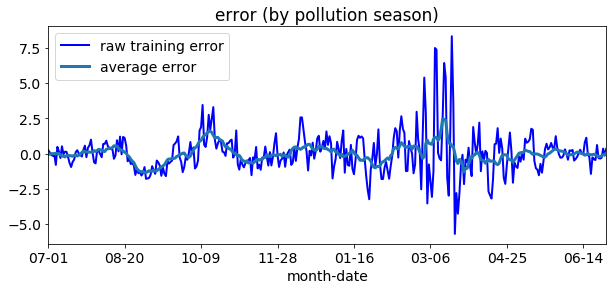

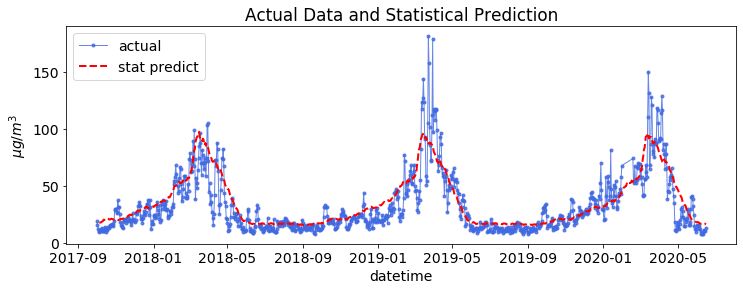

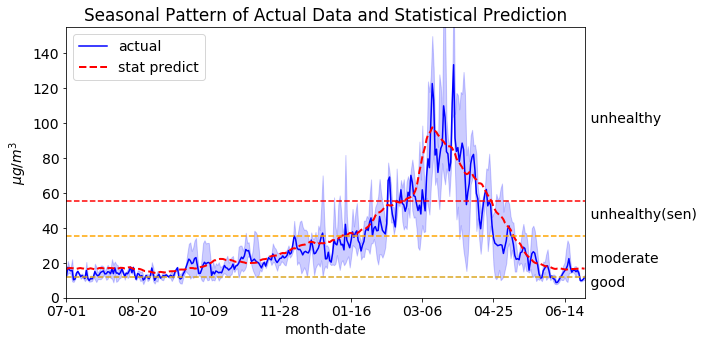

In [104]:
inferer.compare_inf_act()

In [105]:
sea_pred = _reduct_effect_q(inferer.model, inferer.data_samples, ['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700'], inferer.sea_error, q=0.75, per_cut=0.5)

In [32]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


# Effect of Reduced Burning

In the figure below, (top) seasonal pattern of the pollution level when the burning activities are reduced to 100%, 90%, 50%, and 10% in 0 – 700 km radius. 100% means no fire reduction. (bottom) corresponding numbers of hotspots per day in different scenarios. The values above the red line is in the unhealthy range.

## Effect on Seasonal Pattern

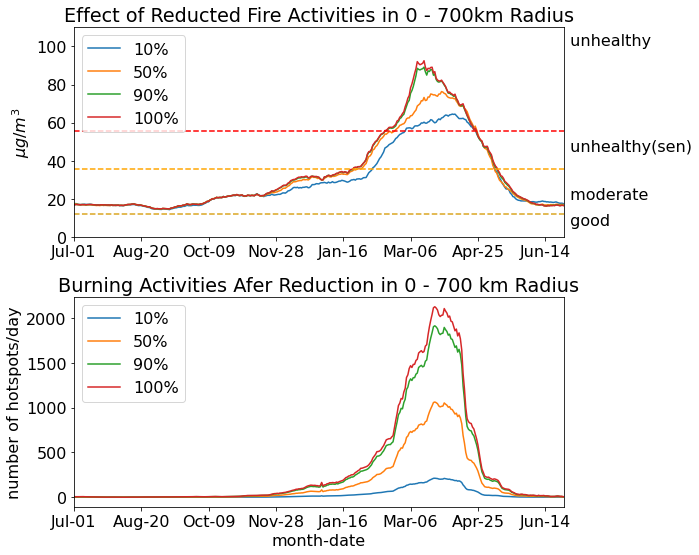

In [83]:
data = inferer.dataset
fire_hour = data.fire[data.fire['distance'] <= 700].copy()
fire_hour = fire_hour[['count']].resample('d').sum()
col = ['number of hotspots']
fire_hour.columns = col
fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
sep_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
sep_fire = sep_fire.groupby('winter_day').mean()[col]
red_list = [0.9, 0.5, 0.1, 0]
red_fire = []
#colors = ['#1f77b4', '#2ca02c', '#9467bd', '#7f7f7f']
for per_cut in red_list:
    temp = sep_fire*(1-per_cut)
    temp.columns = [int(round(1-per_cut,2)*100)]
    red_fire.append(temp)
    
red_fire = pd.concat(red_fire, axis=1)

_, a = plt.subplots(2,1, figsize=(10,8),sharex=True)

ax = a[1]
red_fire.plot(ax=ax)
legends = [ str(s) + '%' for s in red_fire.columns]
ax.legend(legends, loc='upper left')
ax.set_title('Burning Activities Afer Reduction in 0 - 700 km Radius')
ax.set_xlim([red_fire.index.min(), red_fire.index.max()])
new_ticks = ['Jul-01', 'Aug-20', 'Oct-09', 'Nov-28', 'Jan-16', 'Mar-06', 'Apr-25', 'Jun-14', '']    
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')

fea_effect = inferer.features_effect_season(features=['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700'], q=0.75, ax=a[0],red_list=[0.9, 0.5, 0.1, 0])
a[0].set_title('Effect of Reducted Fire Activities in 0 - 700km Radius')
a[0].xaxis.set_tick_params(which='both', labelbottom=True)
a[0].set_xticklabels(new_ticks)
a[0].set_xlabel('month-date')
legends = [ str(s) + '%' for s in red_fire.columns]
a[0].legend(legends, loc='upper left')


plt.tight_layout()

plt.savefig(inferer.report_folder + 'effect_fire_0_700km_sea.png')


In the figure below, (top) seasonal pattern of the pollution level when the burning activities are reduced to 100%, 90%, 50%, and 10% in 0 – 100 km radius. 100% means no fire reduction. (bottom) corresponding numbers of hotspots per day in different scenarios. The values above the red line is in the unhealthy range.

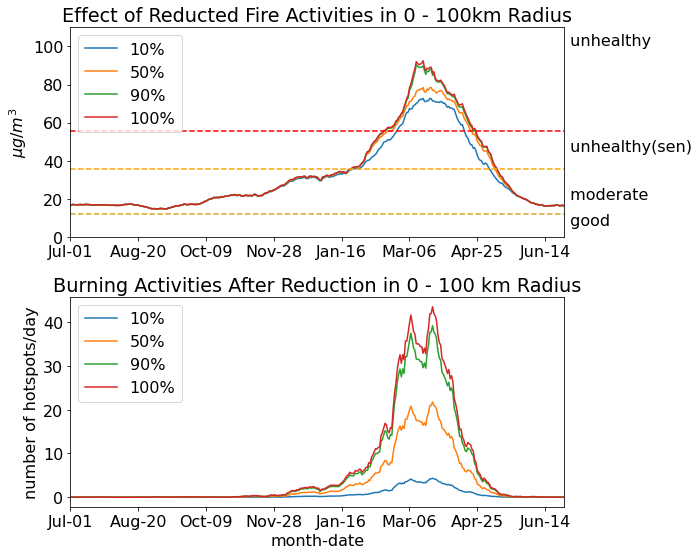

In [82]:
data = inferer.dataset
fire_hour = data.fire[data.fire['distance'] <= 100].copy()
fire_hour = fire_hour[['count']].resample('d').sum()
col = ['number of hotspots']
fire_hour.columns = col
fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
sep_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
sep_fire = sep_fire.groupby('winter_day').mean()[col]
red_list = [0.9, 0.5, 0.1, 0]
red_fire = []
#colors = ['#1f77b4', '#2ca02c', '#9467bd', '#7f7f7f']
for per_cut in red_list:
    temp = sep_fire*(1-per_cut)
    temp.columns = [int(round(1-per_cut,2)*100)]
    red_fire.append(temp)
    
plot_data_list = []    
red_fire = pd.concat(red_fire, axis=1)
plot_data_list.append(red_fire)

_, a = plt.subplots(2,1, figsize=(10,8),sharex=True)

ax = a[1]
red_fire.plot(ax=ax)
legends = [ str(s) + '%' for s in red_fire.columns]
ax.legend(legends, loc='upper left')
ax.set_title('Burning Activities After Reduction in 0 - 100 km Radius')
ax.set_xlim([red_fire.index.min(), red_fire.index.max()])
new_ticks = ['Jul-01', 'Aug-20', 'Oct-09', 'Nov-28', 'Jan-16', 'Mar-06', 'Apr-25', 'Jun-14', '']    
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')

fea_effect = inferer.features_effect_season(features=['fire_0_100'], q=0.75, ax=a[0],red_list=[0.9, 0.5, 0.1, 0])
plot_data_list.append(fea_effect)
a[0].set_title('Effect of Reducted Fire Activities in 0 - 100km Radius')
a[0].xaxis.set_tick_params(which='both', labelbottom=True)
a[0].set_xticklabels(new_ticks)
a[0].set_xlabel('month-date')
plt.tight_layout()
legends = [ str(s) + '%' for s in red_fire.columns]
a[0].legend(legends, loc='upper left')

plt.savefig(inferer.report_folder + 'effect_fire_0_100km_sea.png')

# explore raw plot
h_filename = rawplot_folder +'effect_fire_0_100km_sea'
for i, df in enumerate(plot_data_list):
    df.to_csv(h_filename + f'{i}.csv', index=False)


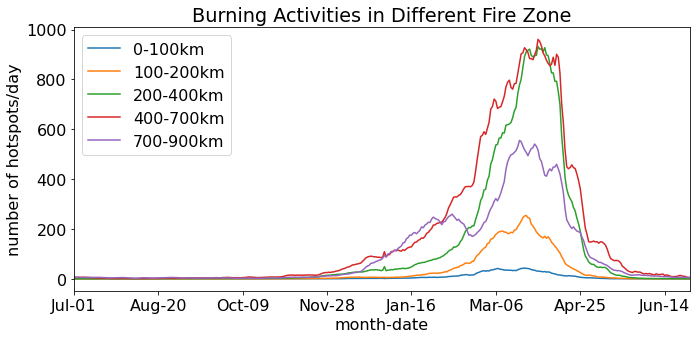

In [84]:
# Plot number of hotspot/day in different fire zone
inner = 0
num_fire_df = []
for distance in inferer.zone_list[1:]: 
    fire_hour = dataset.fire[(dataset.fire['distance']>inner )&(dataset.fire['distance'] <= distance)].copy()
    fire_hour = fire_hour[['count']].resample('d').sum()
    col = [f'{inner}-{distance}km']
    inner = distance
    fire_hour.columns = col 
    fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
    sea_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
    sea_fire = sea_fire.groupby('winter_day').mean()[col]
    num_fire_df.append(sea_fire)
    
num_fire_df = pd.concat(num_fire_df, axis=1)

_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(num_fire_df)
ax.legend(num_fire_df.columns, loc='upper left')
ax.set_title('Burning Activities in Different Fire Zone')
ax.set_xlim([num_fire_df.index.min(), num_fire_df.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
new_ticks = ['Jul-01', 'Aug-20', 'Oct-09', 'Nov-28', 'Jan-16', 'Mar-06', 'Apr-25', 'Jun-14', '']    

ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')
plt.tight_layout()

plt.savefig(inferer.report_folder + 'num_fires_sea.png')

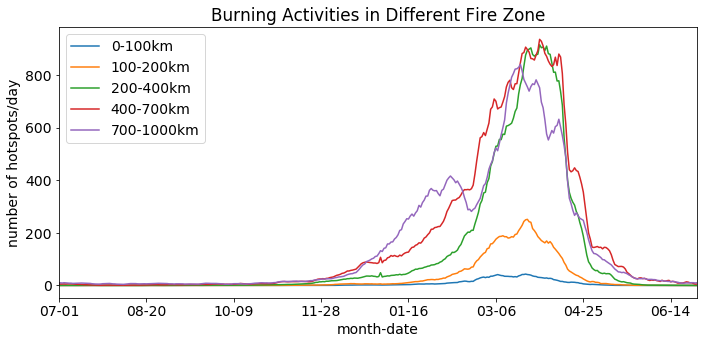

In [38]:
# Plot number of hotspot/day in different fire zone
inner = 0
num_fire_df = []
for distance in inferer.zone_list[1:]: 
    fire_hour = dataset.fire[(dataset.fire['distance']>inner )&(dataset.fire['distance'] <= distance)].copy()
    fire_hour = fire_hour[['count']].resample('d').sum()
    col = [f'{inner}-{distance}km']
    inner = distance
    fire_hour.columns = col 
    fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
    sea_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
    sea_fire = sea_fire.groupby('winter_day').mean()[col]
    num_fire_df.append(sea_fire)
    
num_fire_df = pd.concat(num_fire_df, axis=1)

_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(num_fire_df)
ax.legend(num_fire_df.columns, loc='upper left')
ax.set_title('Burning Activities in Different Fire Zone')
ax.set_xlim([num_fire_df.index.min(), num_fire_df.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
new_ticks = ['Jul-01', 'Aug-20', 'Oct-09', 'Nov-28', 'Jan-16', 'Mar-06', 'Apr-25', 'Jun-14', '']    

ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')
plt.tight_layout()

plt.savefig(inferer.report_folder + 'num_fires_sea.png')


## Effect On Average Pollution Level

In [70]:
%%time

features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5]
zone_list = inferer.zone_list
feature_list = []
columns_list = []
for i in range(1,6):
    fea = features[:i]
    feature_list.append(fea)
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    
rawplot_folder = '../reports/raw_plot/'
fea_effect_3m = inferer.features_effect_sum(feature_list, q=0.75, red_list=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99, 0.999, 0.9999], time_range=[185,305],agg='mean', raw_filename= rawplot_folder +'effect_of_fire_reduction_3m' )
fea_effect_3m.columns = columns_list
# change from percent to whole number
fea_effect_3m.index *= 100
fea_effect_3m.index = fea_effect_3m.index.astype(int)
# save the raw plot for animation 
fea_effect_3m.to_csv(dataset.model_folder +'effect_of_fire_reduction_3m.csv', index=True)


Wall time: 4min 21s


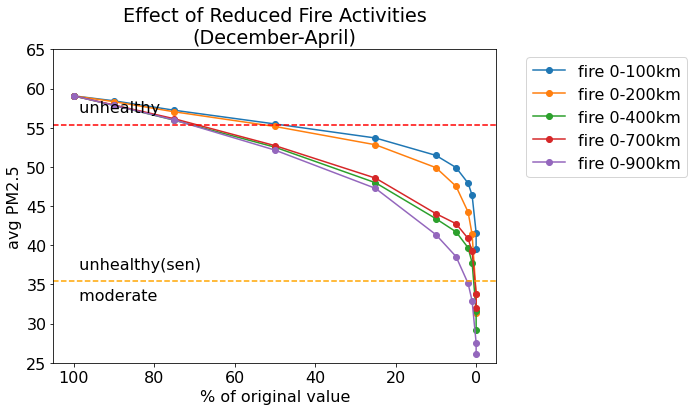

In [78]:
plt.figure(figsize=(10,6))
plt.title("Effect of Reduced Fire Activities\n(December-April)")
columns_list = [fill(l,25) for l in fea_effect_3m.columns]
plt.plot(fea_effect_3m, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([25, 65])

for l, c in inferer.color_zip:
    plt.axhline(l, color=c, linestyle='dashed')
    
plt.text(100, 33, ' moderate',  horizontalalignment='left')
plt.text(100, 37, ' unhealthy(sen)',  horizontalalignment='left')
plt.text(100, 57, ' unhealthy',  horizontalalignment='left')

plt.tight_layout()
plt.savefig(inferer.report_folder + 'effect_of_fire_reduction_3m_v2.png')


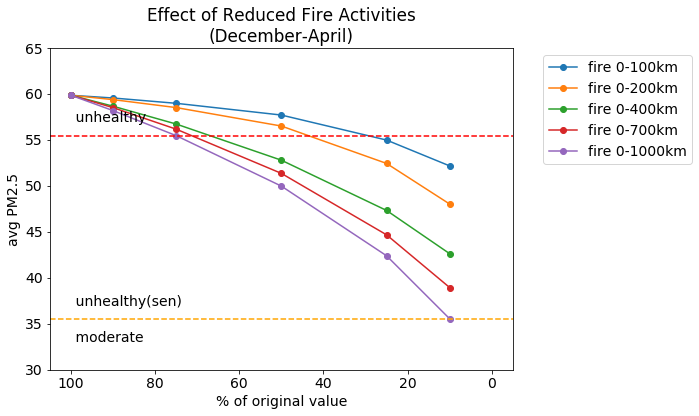

In [86]:
plt.figure(figsize=(10,6))
plt.title("Effect of Reduced Fire Activities\n(December-April)")
columns_list = [fill(l,25) for l in fea_effect_3m.columns]
plt.plot(fea_effect_3m, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([30, 65])

for l, c in inferer.color_zip:
    plt.axhline(l, color=c, linestyle='dashed')
    
plt.text(100, 33, ' moderate',  horizontalalignment='left')
plt.text(100, 37, ' unhealthy(sen)',  horizontalalignment='left')
plt.text(100, 57, ' unhealthy',  horizontalalignment='left')

plt.tight_layout()
plt.savefig(inferer.report_folder + 'effect_of_fire_reduction_3m.png')


In [72]:
%%time

features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5]
zone_list = inferer.zone_list
feature_list = []
columns_list = []
for i in range(1,6):
    fea = features[:i]
    feature_list.append(fea)
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    
fea_effect_mar = inferer.features_effect_sum(feature_list, q=0.75, red_list=[0, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99, 0.999, 0.9999], time_range=[245,275],agg='mean', raw_filename= rawplot_folder +'effect_of_fire_reduction_mar' )
# change from percent to whole number
fea_effect_mar.index *= 100
fea_effect_mar.index = fea_effect_mar.index.astype(int)
fea_effect_mar.to_csv(dataset.model_folder +'effect_of_fire_reduction_mar.csv', index=True)


Wall time: 4min 25s


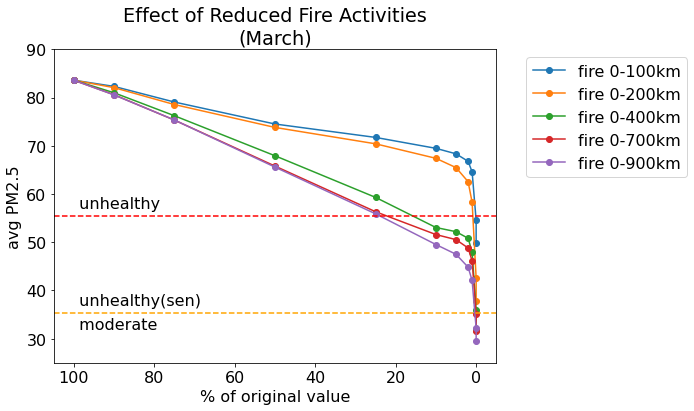

In [79]:
plt.figure(figsize=(10,6))
plt.title("Effect of Reduced Fire Activities\n(March)")
columns_list = [fill(l,20) for l in fea_effect_3m.columns]
plt.plot(fea_effect_mar, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([25, 90])

for l, c in inferer.color_zip: 
    plt.axhline(l, color=c, linestyle='dashed')
    
plt.text(100, 32, ' moderate',  horizontalalignment='left')
plt.text(100, 37, ' unhealthy(sen)',  horizontalalignment='left')
plt.text(100, 57, ' unhealthy',  horizontalalignment='left')
plt.tight_layout()
plt.savefig(inferer.report_folder + 'effect_of_fire_reduction_mar_v2.png')

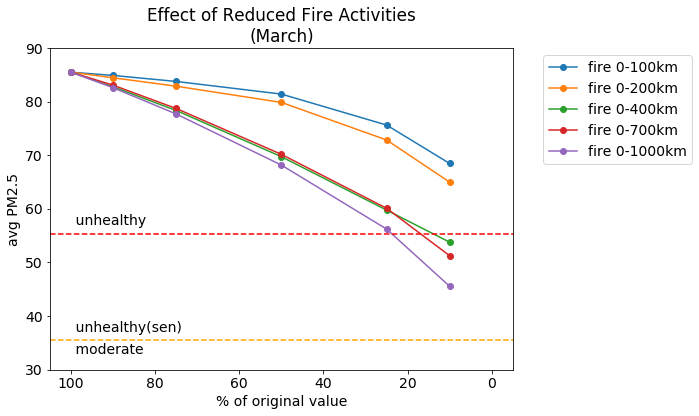

In [87]:
plt.figure(figsize=(10,6))
plt.title("Effect of Reduced Fire Activities\n(March)")
columns_list = [fill(l,20) for l in fea_effect_3m.columns]
plt.plot(fea_effect_mar, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([30, 90])

for l, c in inferer.color_zip: 
    plt.axhline(l, color=c, linestyle='dashed')
    
plt.text(100, 33, ' moderate',  horizontalalignment='left')
plt.text(100, 37, ' unhealthy(sen)',  horizontalalignment='left')
plt.text(100, 57, ' unhealthy',  horizontalalignment='left')
plt.tight_layout()
    
plt.savefig(inferer.report_folder + 'effect_of_fire_reduction_mar.png')

# Animation

In [65]:
def show_city(dataset, stepx=800E3, stepy=800E3, color='black'):
    """Load city location and plot the city center on the map
    
    Args:
        dataset object
        stepx: height of the map in meter 
        stepy: width of the map in meter
        color: color of the circle to mark the city center 
        
    Returns 
        p: bokeh figure object 
        city_x: Longitude in mercator
        city_y: Latitude in mercator 
    """ 
    city_x = merc_x(dataset.city_info['Longitude'])
    city_y = merc_y(dataset.city_info['Latitude'])
    
    x_range = [city_x - stepx, city_x + stepx]
    y_range = [city_y-stepy*0.5, city_y+stepy*0.0001]
    
    p = figure(plot_width=500, plot_height=500, toolbar_location=None, title='burning activities', 
            x_range=x_range, y_range=y_range, x_axis_type="mercator", y_axis_type="mercator")
    
    # add map
    p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))
    
    # add city center 
    #p.circle(city_x, city_y, color=color, line_color='black',size=5, legend_label=dataset.city_name)
   
    return p, city_x, city_y 

In [90]:
def plot_base_effect(df,  title='avg Dec-Apr', plot_width=250, plot_height=250, y_range=[32, 65], color='grey', alpha=1, line_values=[36,56]):
    """Plot base plot of the average pollution level from filename.
    
    Load the file specified by the filename and plot data in grey color 
    
    Args:
        df: dataframe to plot
        title
        plot_width: width of the plot
        plot_height: height of the plot
        color: color of the plot
        y_range: 
        alpha: transparency level 
        line_values: value for the horizontal color lines to make the pollution limit 
        
    Return bokeh figure object 
    
    """
    p = figure(plot_width=plot_width, plot_height=plot_height,  toolbar_location=None, title=title, y_range=y_range,x_range=[105, 0])
    p.xaxis.axis_label = '% of original value'
    p.yaxis.axis_label = 'PM2.5 level(μg/m²)'
    
    # add horizontal lines
    line = Span(location=line_values[0], dimension='width', line_color='orange', line_dash='dashed')
    p.add_layout(line)
    text = Label(x=100, y=32, text='moderate')
    p.add_layout(text)

    line = Span(location=line_values[1], dimension='width', line_color='red', line_dash='dashed')
    p.add_layout(line)
    p.add_layout(Label(x=100, y=37, text='unhealthy(sen)'))
    p.add_layout(Label(x=100, y=61, text='unhealthy'))
    
    
    #df = pd.read_csv(filename)
    
    for col in df.columns:
        p.circle(df.index, df[col],color=color, alpha=alpha)
        p.line(df.index, df[col],color=color, alpha=alpha)
        
    #p.xaxis.ticker = FixedTicker(ticks=[100, 80, 60, 40, 20, 0, -20])
    
    return p
    

In [95]:
def plot_base_season(head_filename, plot_width=250, plot_height=250, color='grey', alpha=1, line_values=[12,35.5,55.5]):
    """Plot base seasonal pattern pollution level from different head_filename.
    
    Load the file specified by the head_filename+*.csv. Load all the data and plot data in grey color 
    
    Args:
        filename: plot data file 
        plot_width: width of the plot
        plot_height: height of the plot
        color: color of the plot
        y_range: 
        alpha: transparency level 
        line_values: value for the horizontal color lines to make the pollution limit 
        
    Return bokeh figure object 
    
    """ 
    p = figure(plot_width=plot_width, plot_height=plot_height, toolbar_location=None, title='seasonal pattern')    
    p.xaxis.axis_label = 'month'
    p.yaxis.axis_label = 'PM2.5 level(μg/m²)'
    
    # add horizontal lines
    p.add_layout(Span(location=line_values[0], dimension='width', line_color='goldenrod', line_dash='dashed'))
    line = Span(location=line_values[1], dimension='width', line_color='orange', line_dash='dashed')
    p.add_layout(line)
    text = Label(x=0, y=21, text='moderate')
    p.add_layout(text)

    line = Span(location=line_values[2], dimension='width', line_color='red', line_dash='dashed')
    p.add_layout(line)
    p.add_layout(Label(x=0, y=40, text='unhealthy(sen)'))
    p.add_layout(Label(x=0, y=62, text='unhealthy(sen)'))
    
    files = glob(head_filename+'*.csv')
    for file in files:
        df = pd.read_csv(file).set_index('winter_day')
        for col in df.columns:
            p.line(df.index, df[col], color=color, alpha=alpha)
    
    # define xticks label 
    
    p.xaxis.ticker = FixedTicker(ticks=[0, 62, 123, 185, 245, 306])
    xaxis_dict = {0:"Jul", 62:"Sept", 123:'Nov' , 185: "Jan", 245: "Mar", 306:"May" }
    p.xaxis.major_label_overrides = xaxis_dict

    
    return p

In [68]:
def plot_one_effet(radius, color, percent, avg_df, filename, p1, p2, p3):
    """Plot individual effect of each fire zone and percent reduction
    
    """
    label = f'0 - {radius}km'
    
    # plot average lines 
    col = f'fire 0-{radius}km'
    p1.line(avg_df.index, avg_df.loc[:, col],color=color,line_width=3)
    p1.circle(percent, avg_df.loc[percent, col],color=color,line_color='black', size=8)
    text = Label(x=5, y=61, text=label, text_font_size='12pt', text_align='right',  text_color=color_list[0])
    p1.add_layout(text)
    
    # plot seasonal line 
    text = Label(x=0, y=90, text=label, text_font_size='12pt', text_align='left', text_color=color_list[0])
    p2.add_layout(text)
    text = Label(x=0, y=80, text=f'{percent}% fire', text_font_size='12pt', text_align='left', text_color=color_list[0])
    p2.add_layout(text)

    df = pd.read_csv(filename).set_index('winter_day')
    p2.line(df.index, df[str(percent)], color=color, line_width=3)
    
    # addcircle to map plot
    xy = get_circle(city_x, city_y,r=radius*1E3)
    p3.line(xy[0,:],xy[1,:],alpha=1,line_width=2,line_color=color, legend_label=label)
    
    # add city center  
    text = Label(x=city_x, y=city_y, text=f'Chiang Mai', text_font_size='15pt', text_color='black')
    p3.add_layout(text)
    # add city center dot
    p3.circle(city_x, city_y, color='black', line_color='black',size=5)
    

In [69]:
# load inference dataset
inferer = Inferer(city_name='Chiang Mai', pollutant='PM2.5')
dataset = inferer.dataset

data no fire has shape (77747, 14)
raw model performance {'test_r2_score': 0.6971263012454727, 'test_mean_squared_error': 236.87171030783028, 'test_mean_absolute_error': 9.356311166795104}
daily avg training error {'avg_trn_r2_score': 0.9750555507848502, 'avg_trn_mean_squared_error': 16.30387143688307, 'avg_trn_mean_absolute_error': 2.4689413599174954}
daily avg test error {'avg_test_r2_score': 0.7774020193313866, 'avg_test_mean_squared_error': 149.34608153552455, 'avg_test_mean_absolute_error': 7.808431861215025}
max error 15.062821731493033


In [70]:
# calculate the number of hotspots between december and april 
inner = 0
num_fire_df = []

for distance in inferer.zone_list[1:]: 
    fire_hour  = dataset.fire[(dataset.fire['distance']>inner )&(dataset.fire['distance'] <= distance)] 
    fire_hour = fire_hour[['count']].resample('d').count().copy()
    col = [f'{inner}-{distance}km']
    inner = distance
    fire_hour.columns = col 
    fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
    sea_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
    sea_fire = sea_fire.groupby('winter_day').mean()[col]
    num_fire_df.append(sea_fire)
    
num_fire_df = pd.concat(num_fire_df, axis=1)

# find starting and stoping day range 
for k, v  in winter_day_dict.items():
    if v == '12-01':
        start_day = int(k)
    
    if v == '04-30':
        end_day = int(k)
        
# obtain total number of hotspots
num_hotspots = num_fire_df.loc[start_day:end_day].sum().astype(int)
print(num_hotspots)

0-100km        2208
100-200km     10926
200-400km     44067
400-700km     58992
700-1000km    53905
dtype: int32


In [71]:
# obtain possible hotspots location 
fire_distances = []
for inner, distance in zip(inferer.zone_list, inferer.zone_list[1:]): 
    fire_hour  = dataset.fire[(dataset.fire['distance']>inner )&(dataset.fire['distance'] <= distance)] 
    fire_hour['dayofyear'] = fire_hour.index.dayofyear
    offset = 182
    # add winter day by substratcing the first day of july
    winterday = fire_hour['dayofyear'] - offset
    # get rid of the negative number
    winter_day_max = winterday.max()
    winterday[winterday < 0] = winterday[winterday < 0] + \
        offset + winter_day_max
    fire_hour['dayofyear'] = winterday
    
    fire_hour = fire_hour.sort_values('dayofyear') 
    # select the data between specified range range 
    fire_hour = fire_hour[(fire_hour['dayofyear']>start_day) & (fire_hour['dayofyear']<=end_day)]
    
    # add coordinate in mercator meter (km is too coarse)
    #fire_hour['long_m'] = merc_x(fire_hour['longitude'])
    #fire_hour['lat_m'] = fire_hour['latitude'].apply(merc_y)
    fire_hour = fire_hour.drop_duplicates(['lat_km', 'long_km'])
     
    fire_hour = fire_hour[['lat_km', 'long_km']] 
      
    print(fire_hour.shape)
    
    
    fire_distances.append(fire_hour)

(16887, 2)
(63770, 2)
(233286, 2)
(395132, 2)
(323205, 2)


In [72]:
# select random position of hotspots
frac_list = np.ones(len(num_hotspots))
positions_list = []
for num, df in zip(num_hotspots, fire_distances):
    num_sample = int(num*1)
    positions = df.sample(num_sample)
    positions_list.append(positions)

In [99]:
ani_folder = '../reports/ani_plot/'

In [74]:
zone_list = inferer.zone_list[1:]
rs = [120, 200, 400 , 700 , 1000]
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
#red_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9]
dataset = inferer.dataset
avg_df = pd.read_csv(f'{ani_folder}effect_of_fire_reduction_3m.csv').set_index('per')
per_list = avg_df.index.to_list()

In [96]:
title = f'Effect of Reduced Fire Activities on PM2.5 level in {dataset.city_name}'

# plot base plots
p1  = plot_base_effect(df=avg_df, alpha=1)
p2 = plot_base_season(head_filename=f'{ani_folder}effect_of_fire_reduction_3m_')
p3, city_x, city_y = show_city(dataset)


i = 1
j = 4

# pick max radius
r = zone_list[i]
# pick line color
color = color_list[i]
# pick percent reduction 
percent = per_list[j]
# build avg label 
label = f'0 - {r}km'

# plot average lines 
p1.line(avg_df.index, avg_df.iloc[:, i],color=color,line_width=3)
p1.circle(per_list[j], avg_df.iloc[j, i],color=color,size=8)
text = Label(x=5, y=61, text=label, text_font_size='12pt', text_align='right',  text_color=color_list[0])
p1.add_layout(text)


# plot seasonal line 
text = Label(x=0, y=90, text=label, text_font_size='12pt', text_align='left', text_color=color_list[0])
p2.add_layout(text)
text = Label(x=0, y=80, text=f'{percent}% fire', text_font_size='12pt', text_align='left', text_color=color_list[0])
p2.add_layout(text)

df = pd.read_csv(f'{ani_folder}effect_of_fire_reduction_3m_{i}.csv').set_index('winter_day')
p2.line(df.index, df[str(percent)], color=color, line_width=3)

# addcircle 
xy = get_circle(city_x, city_y,r=r*1E3)
p3.line(xy[0,:],xy[1,:],alpha=1,line_width=2,line_color=color, legend_label=label)


# add city center 
p3.circle(city_x, city_y, color='black', line_color='black',size=5, legend_label=dataset.city_name)

# plot hotspot 
positions_list_temp = positions_list
frac = percent/100
total_hotspot = []
for ii, (num, df) in enumerate(zip(num_hotspots, positions_list_temp)):
    if ii <= i:
        num_sample = int(num*frac)
        df = df.sample(num_sample)
    total_hotspot.append(len(df))
    p3.circle(df['long_km']*1000, df['lat_km']*1000, size=0.5, color='red',alpha=0.2 )

total_hotspot = np.sum(total_hotspot)
text = Label(x=city_x, y=city_y, text=f'Chiang Mai', text_font_size='15pt', text_color='black')
p3.add_layout(text)
text = Label(x=city_x+0.8E6, y=city_y-0.85E6, text=f' {total_hotspot} hotspots  ', text_font_size='20pt', text_align='right',  text_color='black', background_fill_color='white')
p3.add_layout(text)

p = column(Div(text=f'<h2>{title}</h2>'), row(column(p1, p2), p3))
show(p)
#export_png(p, filename=f"{ani_folder}PNG/{i}_dec_apr.png")

In [97]:
def plot_hotspots(positions_list_temp, num_hotspots, i, percent, p):
    """Add hotspots on the map base on a select position.
    
    Return new_position_list for the next iterations. This help make the hotspots consistent instead of randoms. 
    
    """
    
    frac = percent/100
    total_hotspot = []
    new_position_list = []
    for ii, (num, df) in enumerate(zip(num_hotspots, positions_list_temp)):
        if ii <= i:
            num_sample = int(num*frac)
            df = df.sample(num_sample).copy()
            
        new_position_list.append(df)
        total_hotspot.append(len(df))
        p.circle(df['long_km']*1000, df['lat_km']*1000, size=1, color='red',alpha=0.3 )
    
    
    # add number of hotspots
    total_hotspot = np.sum(total_hotspot)
    text = Label(x=city_x+0.8E6, y=city_y-0.85E6, text=f' {total_hotspot} hotspots  ', text_font_size='20pt', text_align='right',  text_color='black', background_fill_color='white')
    p.add_layout(text)
    return new_position_list

In [100]:
title = f'Effect of Reduced Fire Activities on PM2.5 level in {dataset.city_name}'

for i in range(len(zone_list)):
    # pick max radius
    radius = zone_list[i]
    # pick line color
    color = color_list[i]
    
    
    positions_list_temp = positions_list
    
    for j in range(len(per_list)): 

        # plot base plots
        p1  = plot_base_effect(df=avg_df, alpha=1)
        p2 = plot_base_season(head_filename=f'{ani_folder}effect_of_fire_reduction_3m_')
        p3, city_x, city_y = show_city(dataset)
        # pick percent reduction 
        percent = per_list[j]
        
        positions_list_temp = plot_hotspots(positions_list_temp, num_hotspots, i, percent, p3)
        plot_one_effet(radius, color, percent, avg_df, filename=f'{ani_folder}effect_of_fire_reduction_3m_{i}.csv', p1=p1, p2=p2, p3=p3)
         
        p = column(Div(text=f'<h2>{title}</h2>'), row(column(p1, p2), p3))
        
        #show(p)
        export_png(p, filename=f"{ani_folder}PNG/{i}_{j}_dec_apr.png")

In [1]:
import imageio

In [102]:
# load all the pollution map fire 
filenames = glob(f'{ani_folder}PNG/*.png')

# create a gif showing pollution level for each month
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(f'{ani_folder}eff_reduced_fire1.gif', images, duration=0.5)

# Additional Plot

In [45]:
features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5] 
features = features.to_list()
zone_list = inferer.zone_list
feature_list = []
columns_list = []
max_dis = []
red_list = [1.0, 0.9, 0.5, 0.1, 0]

for i in range(1,6):
    fea = features[:i]
    
    feature_list += fea
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    max_dis.append(zone_list[i])
    
    print(feature_list)
    
    fea_effect =  reduc_effect(model=inferer.model, data_samples=inferer.data_samples, sea_error= inferer.sea_error, features=feature_list, q=0.75, red_list=red_list)
    fea_effect.to_csv(dataset.model_folder + f'fea_effect_maxdis{zone_list[i]}.csv')

['fire_0_100']
['fire_0_100']
fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_

['fire_0_100', 'fire_100_200']
['fire_0_100', 'fire_0_100', 'fire_100_200']
fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_10

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

['fire_0_100', 'fire_100_200', 'fire_700_900']
['fire_0_100', 'fire_0_100', 'fire_100_200', 'fire_0_100', 'fire_100_200', 'fire_700_900']
fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

['fire_0_100', 'fire_100_200', 'fire_700_900', 'fire_400_700']
['fire_0_100', 'fire_0_100', 'fire_100_200', 'fire_0_100', 'fire_100_200', 'fire_700_900', 'fire_0_100', 'fire_100_200', 'fire_700_900', 'fire_400_700']
fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

['fire_0_100', 'fire_100_200', 'fire_700_900', 'fire_400_700', 'fire_200_400']
['fire_0_100', 'fire_0_100', 'fire_100_200', 'fire_0_100', 'fire_100_200', 'fire_700_900', 'fire_0_100', 'fire_100_200', 'fire_700_900', 'fire_400_700', 'fire_0_100', 'fire_100_200', 'fire_700_900', 'fire_400_700', 'fire_200_400']
fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', '

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_

fire_0_100
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_0_100_lag_5', 'fire_0_100_lag_6', 'fire_0_100_lag_7', 'fire_0_100_lag_8', 'fire_0_100_lag_9', 'fire_0_100_lag_10', 'fire_0_100_lag_11', 'fire_0_100_lag_12', 'fire_0_100_lag_13', 'fire_0_100_lag_14', 'fire_0_100_lag_15', 'fire_0_100_lag_16', 'fire_0_100_lag_17', 'fire_0_100_lag_18', 'fire_0_100_lag_19', 'fire_0_100_lag_20', 'fire_0_100_lag_21', 'fire_0_100_lag_22', 'fire_0_100_lag_23', 'fire_0_100_lag_24', 'fire_0_100_lag_25', 'fire_0_100_lag_26', 'fire_0_100_lag_27', 'fire_0_100_lag_28', 'fire_0_100_lag_29', 'fire_0_100_lag_30', 'fire_0_100_lag_31', 'fire_0_100_lag_32', 'fire_0_100_lag_33', 'fire_0_100_lag_34', 'fire_0_100_lag_35', 'fire_0_100_lag_36', 'fire_0_100_lag_37', 'fire_0_100_lag_38', 'fire_0_100_lag_39', 'fire_0_100_lag_40', 'fire_0_100_lag_41', 'fire_0_100_lag_42']
['fire_0_100', 'fire_0_100_lag_1', 'fire_0_100_lag_2', 'fire_0_100_lag_3', 'fire_0_100_lag_4', 'fire_